In [46]:
import json
import os
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import torch

from collections import defaultdict
from pprint import pprint
from typing import Dict, Tuple, List, Callable

from transformers import PreTrainedModel

from src.config.storage import ExperimentType
from src.storage import (
    get_dot_product_paraphrased_files, get_dot_product_model_generated_files,
    get_results_parameters_per_layer_folder_path, get_results_accuracy_per_layer_folder_path,
    get_results_layer_comparison_full_gradient_folder_path,
    get_results_self_similarities_over_layers_folder_path,
    get_gradient_similarity_paraphrased_random_projection_data,
    get_gradient_similarity_model_generated_random_projection_data,
    get_greedy_layer_selection_folder_path,
    get_accuracy_per_layer_boxplot_path
)
from src.dataset import get_samples, get_indices
from src.model import get_model, get_num_parameters_per_layer, get_tokenizer
from src.utility import pprint_messages

import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [47]:
def calculate_cosine_similarity(a_dot_b, a_dot_a, b_dot_b):
    # calculates the cosine similarity based on dot products
    return a_dot_b / (np.sqrt(a_dot_a) * np.sqrt(b_dot_b))

In [48]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [49]:
def calculate_score(gradient_similarities: dict):
    correct_counter = 0
    bm25_correct_counter = 0

    size = len(gradient_similarities.keys())

    for paraphrased_id, similarities in gradient_similarities.items():
        most_similar_original_id = max(similarities, key=similarities.get)
        correct_counter += int(paraphrased_id == most_similar_original_id)

        bm25_most_similar_original_id = list(similarities.keys())[0]
        bm25_correct_counter += int(paraphrased_id == bm25_most_similar_original_id)

    return correct_counter / size, bm25_correct_counter / size

In [50]:
def get_wrong_decisions(gradient_similarities: dict):
    wrong_decisions = []

    for original_id, similarities in gradient_similarities.items():
        most_similar_paraphrased_id = max(similarities, key=similarities.get)
        if original_id != most_similar_paraphrased_id:
            wrong_decisions.append(original_id)

    return wrong_decisions

In [51]:
def get_mean_similarity_of_most_similar_samples(gradient_similarities: dict, mean_function = np.mean):
    highest_similarities = []

    for original_id, similarities in gradient_similarities.items():
        highest_similarities.append(max(similarities.values()))

    return mean_function(highest_similarities)

In [52]:
def calculate_accuracy_per_layer(cosine_similarities_new_structure: dict):
    correct_counter_per_layer = defaultdict(int)

    # amount of paraphrased_samples
    size = len(next(iter(cosine_similarities_new_structure.values())).keys())

    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            most_similar_original_id = max(original_ids, key=original_ids.get)
            correct_counter_per_layer[layer] += int(paraphrased_id == most_similar_original_id)

        # divide by size to get percentage
        correct_counter_per_layer[layer] /= size

    return dict(correct_counter_per_layer)

In [53]:
def get_cosine_similarities(dot_product_storage_function, model_to_evaluate: str, sample_size: int | None) -> \
    tuple[
        dict[str, dict[str, dict[str, float]]],
        dict[str, dict[str, dict[str, float]]],
        dict[str, dict[str, float]],
        dict[str, dict[str, dict[str, tuple[float, float, float]]]]
    ]:
    dot_products, paraphrased_dot_products, original_dot_products = dot_product_storage_function(model_to_evaluate, sample_size)

    # restructure such that layer is at outermost level in the dictionary for easier access afterward
    cosine_similarities_new_structure = dict()
    cosine_similarities_old_structure = dict()

    cosine_similarities_old_structure_combined = dict() # all gradients combined

    layer_dot_products = dict() # stores all the necessary intermediate dot products steps to calculate the cosine similarity for each layer

    for paraphrased_id, values in dot_products.items():
        cosine_similarities_old_structure[paraphrased_id] = dict()
        cosine_similarities_old_structure_combined[paraphrased_id] = dict()

        for original_id, layers in values.items():
            cosine_similarities_old_structure[paraphrased_id][original_id] = dict()
            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = 0

            for layer, value in layers.items():
                if layer not in cosine_similarities_new_structure:
                    cosine_similarities_new_structure[layer] = dict()

                if paraphrased_id not in cosine_similarities_new_structure[layer]:
                    cosine_similarities_new_structure[layer][paraphrased_id] = dict()

                if layer not in layer_dot_products:
                    layer_dot_products[layer] = dict()

                if paraphrased_id not in layer_dot_products[layer]:
                    layer_dot_products[layer][paraphrased_id] = dict()

                similarity = calculate_cosine_similarity(value, paraphrased_dot_products[paraphrased_id][layer], original_dot_products[original_id][layer])

                cosine_similarities_old_structure[paraphrased_id][original_id][layer] = similarity
                cosine_similarities_new_structure[layer][paraphrased_id][original_id] = similarity

                layer_dot_products[layer][paraphrased_id][original_id] = (
                    value,
                    paraphrased_dot_products[paraphrased_id][layer],
                    original_dot_products[original_id][layer]
                )

                cosine_similarities_old_structure_combined[paraphrased_id][original_id] += value

            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = calculate_cosine_similarity(
                cosine_similarities_old_structure_combined[paraphrased_id][original_id],
                sum(paraphrased_dot_products[paraphrased_id].values()),
                sum(original_dot_products[original_id].values())
            )

    # check if restructuring has worked by comparing iteratively with gradient_similarities dictionary
    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            for original_id, similarity in original_ids.items():
                assert similarity == cosine_similarities_old_structure[paraphrased_id][original_id][layer]

    return cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined, layer_dot_products

In [54]:
def avg_by_component(accuracy_per_layer: dict, average_func = np.mean) -> dict:
    """
    Group by component name (embed_tokens, self_attn.q_proj, mlp.down_proj, ...),
    averaging across all layers.
    """
    buckets = defaultdict(list)
    for k, v in accuracy_per_layer.items():
        if k.startswith("model.embed_tokens"):
            comp = "embed_tokens"
        else:
            m = re.match(r"^model\.layers\.\d+\.(?P<comp>[^.]+\.[^.]+)\.", k)
            if not m:
                print(m)
                continue  # skip anything unexpected
            comp = m.group("comp")
        buckets[comp].append(v)
    return {comp: round(average_func(vals), ndigits=3) for comp, vals in buckets.items()}

In [55]:
def calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(
        gradient_similarities_per_layer_new_structure: dict[str, dict[str, dict[str, float]]],
        gradient_similarities_full_gradient_old_structure: dict[str, dict[str, float]],
) -> dict[str, float]:
    # compare each layer with the full gradient

    # flatten full gradient similarities for comparisons
    full_flattened = [item for values in gradient_similarities_full_gradient_old_structure.values() for item in values.values()]

    layer_similarity_compared_to_full_gradients = dict()

    for layer, similarities in gradient_similarities_per_layer_new_structure.items():
        layer_cosine_similarities_flattened = []

        for paraphrased_id, original_similarities in similarities.items():
            layer_cosine_similarities_flattened.extend(original_similarities.values())

        layer_similarity_compared_to_full_gradients[layer] = cosine_similarity(layer_cosine_similarities_flattened, full_flattened)

    return layer_similarity_compared_to_full_gradients

In [56]:
def get_random_projected_similarity_compared_to_full_gradient(
        gradient_similarity_random_projection_storage_function,
        model_to_evaluate: str,
        sample_size: int | None,
        gradient_similarities_full_gradient_old_structure: dict[str, dict[str, float]]
):
    full_flattened = [item for values in gradient_similarities_full_gradient_old_structure.values() for item in values.values()]

    random_projection_similarities_to_full_gradient = dict()

    for projection_dim, down_projected_values in gradient_similarity_random_projection_storage_function(model_to_evaluate, sample_size).items():
        projected_flattened = [item for values in down_projected_values.values() for item in values.values()]

        down_projected_similarity_compared_to_full_gradient = cosine_similarity(projected_flattened, full_flattened)

        random_projection_similarities_to_full_gradient[projection_dim] = down_projected_similarity_compared_to_full_gradient

    return random_projection_similarities_to_full_gradient

In [57]:
def greedy_forward_layer_selection(
    layer_dot_products: Dict[str, Dict[str, Dict[str, Tuple[float, float, float]]]],
    gradient_similarities_full_gradient_old_structure: Dict[str, Dict[str, float]],
) -> List[Tuple[str, float]]:
    """
    :param layer_dot_products:
    {
        "layer_component_1": {
            "paraphrased_id_1: {
                "original_id_a": (float, float, float), # (dot product between layer_component_1 gradient between samples paraphrased_id_1 and original_id_a, self dot product between layer_component_1 gradient of sample paraphrased_id_1 and paraphrased_id_1, self dot product between layer_component_1 gradient of sample original_id_a and original_id_a)
                "original_id_b": (float, float, float), # ...
            },
            "paraphrased_id_2": ...
        },
        layer_component_2: {
            "paraphrased_id_1": {
                "original_id_a": (float, float, float), ...
            ...
        },
        ...
    }
    :param gradient_similarities_full_gradient_old_structure: Has the structure
    {
        "praphrased_id_1": {
            "original_id_a: float, # cosine similarity between gradient paraphrased_id_1 and original_id_a
            "original_id_b: float, # cosine similarity between gradient paraphrased_id_2 and original_id_b
            "original_id_c: float, # cosine similarity between gradient paraphrased_id_3 and original_id_c
            "original_id_d: float, # cosine similarity between gradient paraphrased_id_4 and original_id_d
            "original_id_e: float # cosine similarity between gradient paraphrased_id_5 and original_id_e
        },
        "paraphrased_id_2": {
            "original_id_f: float, # cosine similarity between gradient paraphrased_id_5 and original_id_f
            "original_id_g: float, # cosine similarity between gradient paraphrased_id_6 and original_id_g
            "original_id_h: float, # cosine similarity between gradient paraphrased_id_7 and original_id_h
            "original_id_i: float, # cosine similarity between gradient paraphrased_id_8 and original_id_i
            "original_id_j: float # cosine similarity between gradient paraphrased_id_9 and original_id_j
        },
        ...
    }

    :return:
    """

    # -------------
    # 1) Flatten the (paraphrased_id, original_id) pairs in a fixed order (once)
    #    so we can vectorize all later computations.
    # -------------
    pairs: List[Tuple[str, str]] = []
    full_flattened_list: List[float] = []
    for paraphrased_id, originals in gradient_similarities_full_gradient_old_structure.items():
        for original_id, sim in originals.items():
            pairs.append((paraphrased_id, original_id))
            full_flattened_list.append(sim)

    full_flattened = np.asarray(full_flattened_list, dtype=np.float64)
    full_norm = np.linalg.norm(full_flattened) + 1e-12  # avoid division by zero
    P = len(pairs)

    # -------------
    # 2) Pre-build three NumPy arrays per layer: δ_ij, δ_ii, δ_jj
    #    This removes deep dict lookups and enables vectorized math.
    # -------------
    layer_names = list(layer_dot_products.keys())
    L = len(layer_names)

    # Using dicts of np.ndarray keeps the external interface intact
    delta_ij: Dict[str, np.ndarray] = {}
    delta_ii: Dict[str, np.ndarray] = {}
    delta_jj: Dict[str, np.ndarray] = {}

    for layer in layer_names:
        dp = np.zeros(P, dtype=np.float64)
        pp = np.zeros(P, dtype=np.float64)
        oo = np.zeros(P, dtype=np.float64)

        layer_map = layer_dot_products[layer]
        for idx, (paraphrased_id, original_id) in enumerate(pairs):
            try:
                dot_product, paraphrased_dot_product, original_dot_product = layer_map[paraphrased_id][original_id]
            except KeyError:
                # if the triple is missing for this pair, assume 0.0
                dot_product = paraphrased_dot_product = original_dot_product = 0.0
            dp[idx] = dot_product
            pp[idx] = paraphrased_dot_product
            oo[idx] = original_dot_product

        delta_ij[layer] = dp
        delta_ii[layer] = pp
        delta_jj[layer] = oo

    # -------------
    # 3) Greedy selection with *running accumulators* (no O(t) resumming)
    # -------------
    Dij = np.zeros(P, dtype=np.float64)
    Dii = np.zeros(P, dtype=np.float64)
    Djj = np.zeros(P, dtype=np.float64)

    remaining = set(layer_names)
    best_layers: List[Tuple[str, float]] = []

    eps = 1e-12

    for _ in range(L):
        best_rho = float("-inf")
        best_layer = None
        best_new_Dij = best_new_Dii = best_new_Djj = None

        # loop over remaining candidate layers
        for layer in remaining:
            new_Dij = Dij + delta_ij[layer]
            new_Dii = Dii + delta_ii[layer]
            new_Djj = Djj + delta_jj[layer]

            # cosine similarity reconstruction (vectorized)
            denom = np.sqrt(new_Dii) * np.sqrt(new_Djj)
            # where denom == 0, set c_hat to 0
            c_hat = np.divide(new_Dij, denom + eps, out=np.zeros_like(new_Dij), where=denom > 0)

            # cosine similarity between reconstructed similarities and full similarities
            c_norm = np.linalg.norm(c_hat) + eps

            rho = float(np.dot(c_hat, full_flattened) / (c_norm * full_norm))

            if rho > best_rho:
                best_rho = rho
                best_layer = layer
                best_new_Dij, best_new_Dii, best_new_Djj = new_Dij, new_Dii, new_Djj

        # Commit the winner of this round
        Dij, Dii, Djj = best_new_Dij, best_new_Dii, best_new_Djj
        remaining.remove(best_layer)
        best_layers.append((best_layer, best_rho))

    return best_layers

In [58]:
def find_top_k_examples_where_similarity_diverges_between_single_layer_gradient_and_full_gradient(
        layer_under_investigation: str,
        gradient_similarities_per_layer: dict[str, dict[str, dict[str, float]]],
        gradient_similarities_full_gradient: dict[str, dict[str, float]],
        k=3
) -> list[str]:
    # TODO: currently most divergent examples are used, however we want to have examples where the layer under investigation scores high and the full gradient scores worse
    layer_gradient_similarities = gradient_similarities_per_layer[layer_under_investigation]

    similarities = []

    for paraphrased_id, gradient_cosine_similarities in layer_gradient_similarities.items():
        if not gradient_cosine_similarities.keys() & gradient_similarities_full_gradient[paraphrased_id].keys():
            raise Exception(f"Paraphrased ID {paraphrased_id} does not have gradient similarities")

        similarities_sample = np.array(list(gradient_cosine_similarities.values()))
        similarities_full_gradient = np.array(list(gradient_similarities_full_gradient[paraphrased_id].values()))

        similarities.append(cosine_similarity(similarities_sample, similarities_full_gradient))

    most_divergent_example_indices = np.argsort(np.array(similarities))[:k]

    return list(np.array(list(layer_gradient_similarities.keys()))[most_divergent_example_indices])

In [59]:
def remove_strings_from_dataframe_column(column: pd.Series):
    return (column.astype(str)
            .str.replace(r"\bmodel.\b", "", case=False, regex=True)
            .str.replace(r"\blayers.\b", "", case=False, regex=True)
            .str.replace(r"\b.weight\b", "", case=False, regex=True)
            .str.replace(r"\s+", " ", regex=True)   # collapse extra spaces
            .str.strip())

In [60]:
def get_component_type(label):
    """Extracts the component type from a full layer label."""
    if 'embed_tokens' in label:
        return 'embed_tokens'
    parts = label.split('.')
    if len(parts) > 2:
        return '.'.join(parts[-2:])
    return label

def get_layer_label(label) -> int:
    """Extracts a label for the layer depth."""
    if 'embed_tokens' in label:
        return -1
    parts = label.split('.')
    if len(parts) > 1 and parts[0].isdigit():
        return int(parts[0])
    return -100 # Fallback for unexpected formats

In [61]:
def bar_plot(y, x, title, storage_folder_path, scale=None, y_axis_label:str=None):
    # --- Initial DataFrame setup (same as before) ---
    df = pd.DataFrame({"y": y, "x": x})
    df["y"] = remove_strings_from_dataframe_column(df["y"])

    # --- SETUP FOR COLORS AND LABELS ---
    df['component_type'] = df['y'].apply(get_component_type)
    df['layer_label'] = df['y'].apply(get_layer_label)

    # Sort values for a logical x-axis order (Embed, 0, 1, 2...)
    df = df.sort_values(by=['layer_label', 'component_type'], ascending=[True, True])

    # Create a display-friendly label for the x-axis, replacing -1 with 'Embed'
    df['display_label'] = df['layer_label'].astype(str).replace({'-1': 'Embed'})

    # --- Setup for plot and colors ---
    unique_types = sorted(df['component_type'].unique())
    palette = sns.color_palette("tab10", n_colors=len(unique_types))
    color_map = dict(zip(unique_types, palette))

    # Adjust figsize for a vertical aspect ratio (wider than it is tall)
    plt.figure(figsize=(16, 8))

    # --- CORE CHANGE: Create a vertical bar plot ---
    ax = sns.barplot(
        x=df['display_label'],    # Categorical axis is now x
        y=df["x"],                # Numerical axis is now y
        hue=df['component_type'],
        palette=color_map,
        width=1
    )

    # --- AXIS, LEGEND, AND SCALE MODIFICATIONS ---
    ax.legend(title='Component Type', frameon=False)

    # If a log scale is requested, apply it to the y-axis
    if scale == 'log':
        ax.set_yscale('log')

    if y_axis_label:
        plt.ylabel(y_axis_label)

    # Adjust axis labels for vertical orientation
    plt.xlabel("Layer Depth")

    #plt.title(title)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.savefig(f"{storage_folder_path}/bar_plot.png", bbox_inches="tight", dpi=300)
    plt.show()

In [62]:
def plot_gradient_similarities_over_layers(
        examples: list[str],
        gradient_similarities_per_layer_old_structure: dict[str, dict[str, dict[str, float]]],
        title: str,
        experiment_type: ExperimentType
):
    for paraphrased_example_under_investigation in examples:
        gradient_similarities_over_layers = pd.DataFrame(
            data=list(gradient_similarities_per_layer_old_structure["lima_0"]["lima_0"].keys()),
            columns=["layer"]
        )

        gradient_similarities_over_layers["layer"] = remove_strings_from_dataframe_column(gradient_similarities_over_layers["layer"])

        for original_example_to_compare in gradient_similarities_per_layer_old_structure[paraphrased_example_under_investigation]:
            gradient_similarities_over_layers[f"{paraphrased_example_under_investigation} <=> {original_example_to_compare}"] = list(gradient_similarities_per_layer_old_structure[paraphrased_example_under_investigation][original_example_to_compare].values())

        gradient_similarities_over_layers = gradient_similarities_over_layers.set_index("layer")

        plt.figure(figsize=(18, 8))
        sns.lineplot(data=gradient_similarities_over_layers)
        plt.ylabel("gradient similarity")
        plt.title(title)
        plt.xticks(rotation=90)

        plt.margins(y=0.01)

        storage_path = get_results_self_similarities_over_layers_folder_path(paraphrased_example_under_investigation, model_to_evaluate, experiment_type)

        plt.savefig(f"{storage_path}/line_plot.png", bbox_inches="tight", dpi=300)

        plt.show()

        gradient_similarities_over_layers.to_csv(os.path.join(storage_path, "gradient_similarities_over_layers.csv"))

In [63]:
def create_accumulated_plot_for_greedy_forward_layer_selection(
        greedily_selected_layers: list[tuple[str, float]],
        gradient_similarity_random_projection_data_storage_function,
        cosine_similarities_old_structure_combined: dict[str, dict[str, float]],
        model_to_evaluate: str,
        sample_size: int | None,
        experiment_type: ExperimentType
):
    # accumulate layer parameters for visualization
    parameter_percentage_accumulated_and_similarity_paraphrased = []
    accumulated_parameters = 0

    for layer, similarity_compared_to_full_gradient in greedily_selected_layers:
        accumulated_parameters += num_parameters_per_layer[layer]

        parameter_percentage_accumulated_and_similarity_paraphrased.append((accumulated_parameters / model.num_parameters() * 100, similarity_compared_to_full_gradient))

    down_projected_gradients_paraphrased_compared_to_full_gradient = get_random_projected_similarity_compared_to_full_gradient(
        gradient_similarity_random_projection_data_storage_function,
        model_to_evaluate,
        sample_size,
        cosine_similarities_old_structure_combined
    )

    sns.lineplot(data=pd.DataFrame(data=parameter_percentage_accumulated_and_similarity_paraphrased, columns=["percentage", 'similarity']), x="percentage", y="similarity", label="Greedy (similarity)")

    colors = plt.get_cmap("Reds")(np.linspace(0.3, 1, len(down_projected_gradients_paraphrased_compared_to_full_gradient)))

    for (i, (projection_dim, similarity)) in enumerate(down_projected_gradients_paraphrased_compared_to_full_gradient.items()):
        percentage_of_full_parameters = int(projection_dim) / model.num_parameters() * 100
        plt.plot(
            percentage_of_full_parameters,
            similarity,
            "o",
            color=colors[i],
            label=f"{round(percentage_of_full_parameters)}% of params random projected"
        )

    plt.axhline(y=1.0, color="r", linestyle="--", label="Full gradient (all model parameters)")

    #plt.title(f"{model_to_evaluate} - {experiment_type.value} - greedy layer selection",)
    plt.legend()
    plt.xlabel("% of model parameters (cumulative)")
    plt.ylabel("Similarity")

    plt.savefig(f"{get_greedy_layer_selection_folder_path(model_to_evaluate, sample_size, experiment_type)}/plot.png", bbox_inches="tight", dpi=300)

    plt.show()

In [64]:
def compute_accuracy_from_accumulated_dot_products(
    accum: Dict[str, Dict[str, Tuple[float, float, float]]],
    eps: float = 1e-12
) -> float:
    correct = 0
    total = 0
    for paraphrased_id, original_map in accum.items():
        best_orig = None
        best_score = -1.0
        for original_id, (Dij, Dii, Djj) in original_map.items():
            denom = (Dii * Djj) ** 0.5
            if denom <= eps:
                sim = -np.inf
            else:
                sim = Dij / max(denom, eps)
            if sim > best_score:
                best_score = sim
                best_orig = original_id
        if best_orig is not None:
            correct += int(best_orig == paraphrased_id)
            total += 1
    return 0.0 if total == 0 else correct / total


def _compute_accuracy_from_nested_similarity(values: Dict[str, Dict[str, float]]) -> float:
    """
    values: {paraphrased_id: {original_id: similarity_score}}
    Returns top-1 retrieval accuracy.
    """
    correct, total = 0, 0
    for paraphrased_id, o_map in values.items():
        if not o_map:
            continue
        best_orig = max(o_map.items(), key=lambda kv: kv[1])[0]
        correct += int(best_orig == paraphrased_id)
        total += 1
    return 0.0 if total == 0 else correct / total

In [65]:
def greedy_forward_layer_selection_by_accuracy(
    layer_dot_products: Dict[str, Dict[str, Dict[str, Tuple[float, float, float]]]],
) -> List[Tuple[str, float]]:
    skeleton: Dict[str, Dict[str, Tuple[float, float, float]]] = defaultdict(dict)
    for layer, p_map in layer_dot_products.items():
        for paraphrased_id, o_map in p_map.items():
            for original_id, triplet in o_map.items():
                if original_id not in skeleton[paraphrased_id]:
                    skeleton[paraphrased_id][original_id] = (0.0, 0.0, 0.0)

    accum = {p: {o: (0.0, 0.0, 0.0) for o in o_map} for p, o_map in skeleton.items()}

    remaining = set(layer_dot_products.keys())
    selected_with_acc: List[Tuple[str, float]] = []

    while remaining:
        best_layer = None
        best_acc = -1.0
        best_new_accum = None

        for layer in list(remaining):
            temp_accum = {}
            layer_map = layer_dot_products[layer]
            for p, o_map in accum.items():
                temp_accum[p] = {}
                for o, (Dij, Dii, Djj) in o_map.items():
                    add_Dij, add_Dii, add_Djj = layer_map.get(p, {}).get(o, (0.0, 0.0, 0.0))
                    temp_accum[p][o] = (Dij + add_Dij, Dii + add_Dii, Djj + add_Djj)

            acc = compute_accuracy_from_accumulated_dot_products(temp_accum)

            if acc > best_acc:
                best_acc = acc
                best_layer = layer
                best_new_accum = temp_accum

        if best_layer is None:
            break

        accum = best_new_accum
        remaining.remove(best_layer)
        selected_with_acc.append((best_layer, float(best_acc)))

    return selected_with_acc

In [66]:
def create_accumulated_accuracy_plot_for_greedy_forward_layer_selection(
    greedily_selected_layers_by_accuracy: List[Tuple[str, float]],
    model: PreTrainedModel,
    num_parameters_per_layer: Dict[str, int],
    model_to_evaluate: str,
    sample_size: int | None,
    experiment_type : ExperimentType,
    random_projection_storage_function: Callable[[str | None, int | None], Dict[str, Dict[str, Dict[str, float]]]],
    full_gradient_score: float
):
    # Build the curve
    xs = []
    ys = []
    accumulated_params = 0

    for layer_name, acc in greedily_selected_layers_by_accuracy:
        layer_params = int(num_parameters_per_layer.get(layer_name, 0))
        accumulated_params += layer_params
        pct = (accumulated_params / max(model.num_parameters(), 1)) * 100.0
        xs.append(pct)
        ys.append(acc)

    plt.figure()
    plt.plot(xs, ys, label="Greedy (accuracy)")
    plt.xlabel("% of model parameters (cumulative)")
    plt.ylabel("Accuracy")

    #plt.title(f"{model_to_evaluate} - {experiment_type.value} - greedy layer selection by accuracy")

    rp_data = random_projection_storage_function(model_to_evaluate, sample_size)

    colors = plt.get_cmap("Reds")(np.linspace(0.3, 1, len(rp_data)))

    plt.axhline(y=full_gradient_score, color="r", linestyle="--", label="Full gradient (all model parameters)")

    for i, dim in enumerate(rp_data.keys()):
        nested_vals = rp_data[dim]  # {paraphrased_id: {original_id: sim}}
        y = _compute_accuracy_from_nested_similarity(nested_vals)
        x = (int(dim) / max(model.num_parameters(), 1)) * 100.0
        plt.scatter([x], [y], marker="o", label=f"{round(x)}% of params random projected", color=colors[i])

    plt.legend()
    plt.savefig(f"{get_greedy_layer_selection_folder_path(model_to_evaluate, sample_size, experiment_type)}/accuracy_plot.png", bbox_inches="tight", dpi=300)
    plt.show()

In [67]:
def create_accuracy_per_layer_boxplot(
        accuracy_per_layer: dict[str, float],
        num_parameters_per_layer: dict[str, int],
        model_to_evaluate: str,
        sample_size: int | None,
        experiment_type: ExperimentType,
):
    num_parameters = [num_parameters_per_layer[k] for k in accuracy_per_layer.keys()]
    accuracy = list(accuracy_per_layer.values())

    # 1) group accuracies by exact parameter count
    groups = defaultdict(list)
    for n, acc in zip(num_parameters, accuracy):
        groups[n].append(acc)

    # 2) sort groups by parameter count
    labels, data = zip(*sorted(groups.items(), key=lambda x: x[0]))

    # 3) plot
    plt.figure(figsize=(6,4))
    plt.boxplot(data, tick_labels=[f'{n:,}' for n in labels], showmeans=True)
    plt.xlabel('Number of parameters')
    plt.ylabel('Accuracy')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()

    plt.savefig(get_accuracy_per_layer_boxplot_path(model_to_evaluate, sample_size, experiment_type), bbox_inches="tight", dpi=300)

    plt.show()

In [68]:
def plot_olmo_layer_component_accuracy(
    acc_dict: dict,
    model_to_evaluate: str,
    sample_size: int | None,
    experiment_type: ExperimentType,
    attn_label: str = "self_attn",
    mlp_label: str = "mlp"
) -> None:
    """
    Parse accuracy_per_layer dict and plot:
      (1) Attention vs MLP (mean over subcomponents per layer)
      (2) Attention subcomponents over depth: query, key, value, output
      (3) MLP subcomponents over depth: gate, up, down

    Args:
      acc_dict: mapping {param_name -> accuracy}, where param_name looks like:
        'model.layers.{L}.self_attn.{q_proj|k_proj|v_proj|o_proj}.weight'
        'model.layers.{L}.mlp.{gate_proj|up_proj|down_proj}.weight'
      depth_start: 0 (default) to use 0-based depth on x-axis; set to 1 for 1-based.
      save_dir: if provided, saves PNGs there as:
        overall_attention_vs_mlp.png, attention_components.png, mlp_components.png
      attn_label: label for the aggregated attention line
      mlp_label:  label for the aggregated MLP line
    """

    # --- Parse dict into per-layer structures ---
    attn_map = {"q_proj": "query", "k_proj": "key", "v_proj": "value", "o_proj": "output"}
    mlp_map  = {"gate_proj": "gate", "up_proj": "up", "down_proj": "down"}

    pat = re.compile(
        r"^model\.layers\.(\d+)\.(self_attn|mlp)\."
        r"(q_proj|k_proj|v_proj|o_proj|gate_proj|up_proj|down_proj)\.weight$"
    )

    # component_series["attn/query"][layer] = accuracy, etc.
    component_series: dict[str, dict[int, float]] = defaultdict(dict)
    layers_seen = set()

    for name, acc in acc_dict.items():
        m = pat.match(name)
        if not m:
            # ignore things like model.embed_tokens.weight
            continue
        layer = int(m.group(1))
        block = m.group(2)          # "self_attn" or "mlp"
        proj  = m.group(3)

        if block == "self_attn":
            comp = attn_map.get(proj)
            if not comp:
                continue
            key = f"attn/{comp}"
        else:
            comp = mlp_map.get(proj)
            if not comp:
                continue
            key = f"mlp/{comp}"

        component_series[key][layer] = float(acc)
        layers_seen.add(layer)

    if not layers_seen:
        raise ValueError("No matching layer components found in the provided dict.")

    layers = sorted(layers_seen)

    # Helper to extract y for a given component name across all layers
    def ys_for(comp_key: str) -> list[float]:
        series = component_series.get(comp_key, {})
        return [series.get(l, float("nan")) for l in layers]

    # --- Figure 1: overall Attention vs MLP (mean of subcomponents) ---
    def mean_ignore_nan(values):
        vals = [v for v in values if v == v]  # drop NaN
        if not vals:
            return float("nan")
        return sum(vals) / len(vals)

    attn_subs = ["attn/query", "attn/key", "attn/value", "attn/output"]
    mlp_subs  = ["mlp/gate", "mlp/up", "mlp/down"]

    attn_overall = [
        mean_ignore_nan([component_series[s].get(l, float("nan")) for s in attn_subs])
        for l in layers
    ]
    mlp_overall = [
        mean_ignore_nan([component_series[s].get(l, float("nan")) for s in mlp_subs])
        for l in layers
    ]

    plt.figure()
    plt.plot(layers, attn_overall, label=attn_label)
    plt.plot(layers, mlp_overall, label=mlp_label)
    plt.xlabel("Layer depth")
    plt.ylabel("Accuracy")
    #plt.title("Attention vs MLP (mean across subcomponents)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, experiment_type), "overall_attention_vs_mlp.png"), dpi=300, bbox_inches="tight")
    plt.show()

    # --- Figure 2: Attention subcomponents (query, key, value, output) ---
    plt.figure()
    for comp in attn_subs:
        # Label just the sub-name (after 'attn/')
        label = comp.split("/", 1)[1]
        plt.plot(layers, ys_for(comp), label=label)
    plt.xlabel("Layer depth")
    plt.ylabel("Accuracy")
    #plt.title("Attention components over depth")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, experiment_type), "attention_components.png"), dpi=300, bbox_inches="tight")
    plt.show()

    # --- Figure 3: MLP subcomponents (gate, up, down) ---
    plt.figure()
    for comp in mlp_subs:
        label = comp.split("/", 1)[1]
        plt.plot(layers, ys_for(comp), label=label)
    plt.xlabel("Layer depth") # plt.xlabel(r"Layer depth $l$") # for latex notation
    plt.ylabel("Accuracy")
    #plt.title("MLP components over depth")
    plt.legend()
    plt.grid(True)

    plt.savefig(os.path.join(get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, experiment_type), "mlp_components.png"), dpi=300, bbox_inches="tight")
    plt.show()


In [69]:
model_to_evaluate = "amd/AMD-OLMo-1B-SFT"
#model_to_evaluate = "allenai/OLMo-7B-SFT-hf"
#sample_size = 100
sample_size = None

#model_to_evaluate = "openai-community/gpt2"
#sample_size = 2

In [70]:
tokenizer = get_tokenizer(model_to_evaluate)
model = get_model(model_to_evaluate, device=torch.device('cpu')) # load model on cpu since no more computations are needed

Device: cpu
Model parameters: 1176764416
OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
    (rotary_emb)

In [71]:
num_parameters_per_layer = get_num_parameters_per_layer(model)

assert sum(num_parameters_per_layer.values()) == model.num_parameters()

pprint(num_parameters_per_layer, indent=4, sort_dicts=False)

{   'model.embed_tokens.weight': 103022592,
    'model.layers.0.self_attn.q_proj.weight': 4194304,
    'model.layers.0.self_attn.k_proj.weight': 4194304,
    'model.layers.0.self_attn.v_proj.weight': 4194304,
    'model.layers.0.self_attn.o_proj.weight': 4194304,
    'model.layers.0.mlp.gate_proj.weight': 16777216,
    'model.layers.0.mlp.up_proj.weight': 16777216,
    'model.layers.0.mlp.down_proj.weight': 16777216,
    'model.layers.1.self_attn.q_proj.weight': 4194304,
    'model.layers.1.self_attn.k_proj.weight': 4194304,
    'model.layers.1.self_attn.v_proj.weight': 4194304,
    'model.layers.1.self_attn.o_proj.weight': 4194304,
    'model.layers.1.mlp.gate_proj.weight': 16777216,
    'model.layers.1.mlp.up_proj.weight': 16777216,
    'model.layers.1.mlp.down_proj.weight': 16777216,
    'model.layers.2.self_attn.q_proj.weight': 4194304,
    'model.layers.2.self_attn.k_proj.weight': 4194304,
    'model.layers.2.self_attn.v_proj.weight': 4194304,
    'model.layers.2.self_attn.o_proj.

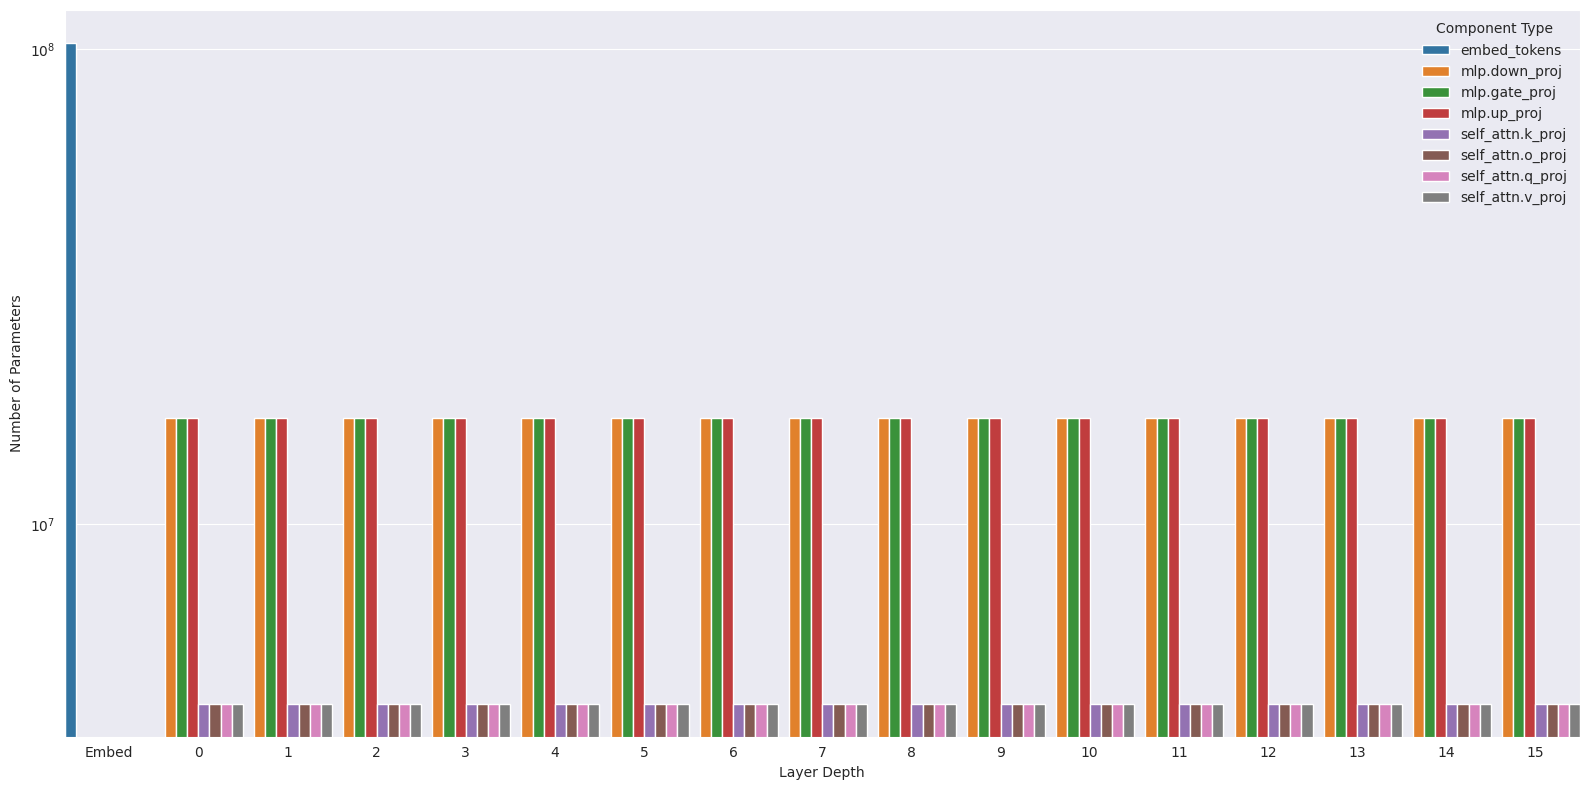

In [72]:
bar_plot(
    y=list(num_parameters_per_layer.keys()),
    x=list(num_parameters_per_layer.values()),
    title=f"{model_to_evaluate} - parameters per layer",
    storage_folder_path=f"{get_results_parameters_per_layer_folder_path(model_to_evaluate)}",
    scale='log',
    y_axis_label="Number of Parameters"
)

with open(f"{get_results_parameters_per_layer_folder_path(model_to_evaluate)}/values.json", "w") as f:
    json.dump(num_parameters_per_layer, f, indent=4)

In [73]:
cosine_similarities_new_structure_paraphrased, cosine_similarities_old_structure_paraphrased, cosine_similarities_old_structure_combined_paraphrased, layer_dot_products_paraphrased = get_cosine_similarities(get_dot_product_paraphrased_files, model_to_evaluate, sample_size)

# 1. BM25 Selected Paraphrased

In [74]:
model_score, bm25_score = calculate_score(cosine_similarities_old_structure_combined_paraphrased)
wrong_decisions = get_wrong_decisions(cosine_similarities_old_structure_combined_paraphrased)
mean_similarity = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_paraphrased)
mean_similarity_score_median = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_paraphrased, np.median)

print(f"Model score: {model_score}")
print(f"BM25 score: {bm25_score}")
print(f"Mean similarity (average): {mean_similarity}")
print(f"Mean similarity (median): {mean_similarity_score_median}")
print(f"Wrong decisions: {wrong_decisions}")

Model score: 0.992914979757085
BM25 score: 0.8360323886639676
Mean similarity (average): 0.4453259535564719
Mean similarity (median): 0.43923551600197697
Wrong decisions: ['lima_725', 'lima_767', 'lima_773', 'lima_802', 'lima_815', 'lima_832', 'lima_849']


In [75]:
wrong_samples_paraphrased = get_samples(wrong_decisions)

In [76]:
get_indices(wrong_decisions)

[714, 756, 762, 791, 804, 821, 838]

In [77]:
fmt = f"{{:>{8}}} - {{:>{3}}}, {{:>{4}}} | {{:>{3}}}, {{:>{4}}} | {{:>{3}}}, {{:>{4}}}"

for wrong_sample in wrong_samples_paraphrased:
    amount_tokens_original_user_message = len(tokenizer.apply_chat_template([wrong_sample["messages"][0]]))
    amount_tokens_original_assistant_message = len(tokenizer.apply_chat_template([wrong_sample["messages"][1]]))

    amount_tokens_paraphrased_user_message = len(tokenizer.apply_chat_template([wrong_sample["paraphrased_messages"][0]]))
    amount_tokens_paraphrased_assistant_message = len(tokenizer.apply_chat_template([wrong_sample["paraphrased_messages"][1]]))

    amount_tokens_model_generated_user_message = len(tokenizer.apply_chat_template([wrong_sample["model_generated_messages"][0]]))
    amount_tokens_model_generated_assistant_message = len(tokenizer.apply_chat_template([wrong_sample["model_generated_messages"][1]]))

    print(fmt.format(wrong_sample["id"], amount_tokens_original_user_message, amount_tokens_original_assistant_message, amount_tokens_paraphrased_user_message, amount_tokens_paraphrased_assistant_message, amount_tokens_model_generated_user_message, amount_tokens_model_generated_assistant_message))

lima_725 -  15, 3108 |  18, 2165 |  18,  129
lima_767 -  11, 2952 |  15, 2254 |  15,  330
lima_773 -  17, 3209 |  20, 2233 |  20,  273
lima_802 -  44,   21 |  21,   25 |  21,   58
lima_815 - 137,   43 |  34,   39 |  34,  321
lima_832 -  31,   38 |  38,   39 |  38,  169
lima_849 -  81,   48 |  49,   46 |  49,  237


In [78]:
wrong_samples_paraphrased[6]

{'id': 'lima_849',
 'messages': [{'role': 'user',
   'content': 'translate into English: "Der Zug kommt in Frankfurt pünktlich an. Kerstin geht sofort nach Hause, aber während sie die Treppen hochsteigt, bemerkt sie einige eigenartige Dinge: bunte Luftballons, rote Kärtchen in Herzform, rote Rosen."'},
  {'role': 'assistant',
   'content': 'The train arrives at Frankfurt on time. Kerstin goes straight home but, climbing the stairs, she notices some strange things: coloured balloons, red cards in the shape of a heart, red roses.'}],
 'paraphrased_messages': [{'content': '"The train arrives in Frankfurt on time. Kerstin heads home immediately, but as she climbs the stairs, she notices some strange things: colorful balloons, red heart-shaped cards, and red roses."',
   'role': 'user'},
  {'content': 'The train reaches Frankfurt punctually. Kerstin heads directly home, but while ascending the stairs, she observes some peculiar items: colorful balloons, heart-shaped red cards, and red roses

## 1.1 Layer Analysis

In [79]:
accuracy_per_layer_paraphrased = calculate_accuracy_per_layer(cosine_similarities_new_structure_paraphrased)

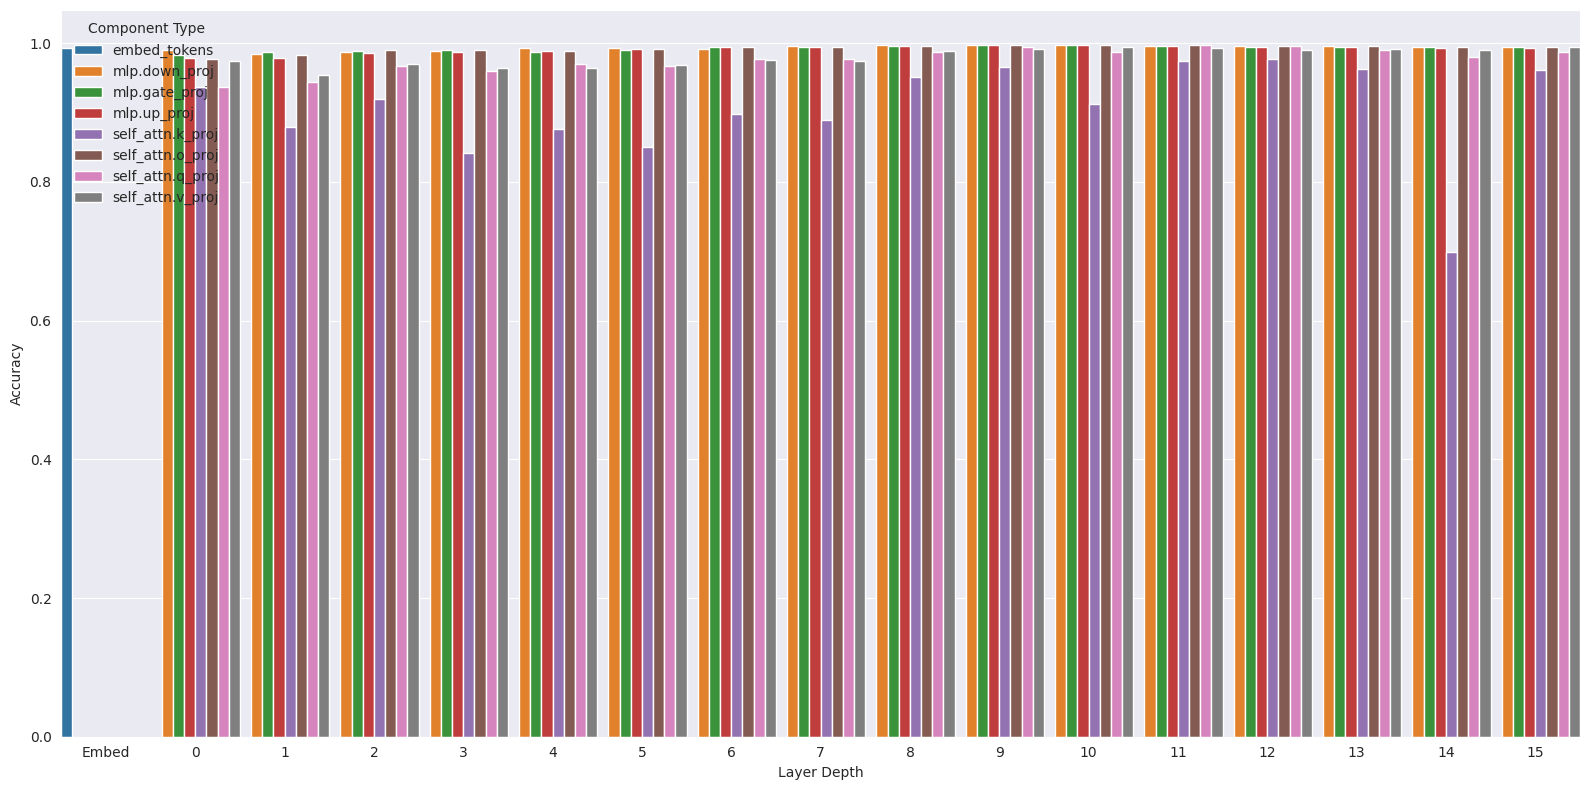

In [80]:
bar_plot(
    y=list(accuracy_per_layer_paraphrased.keys()),
    x=list(accuracy_per_layer_paraphrased.values()),
    title=f"{model_to_evaluate} - paraphrased - accuracy per layer",
    storage_folder_path=get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED),
    #ma_window=7
    y_axis_label="Accuracy"
)

with open(f"{get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED)}/values.json", "w") as f:
    json.dump(accuracy_per_layer_paraphrased, f, indent=4)

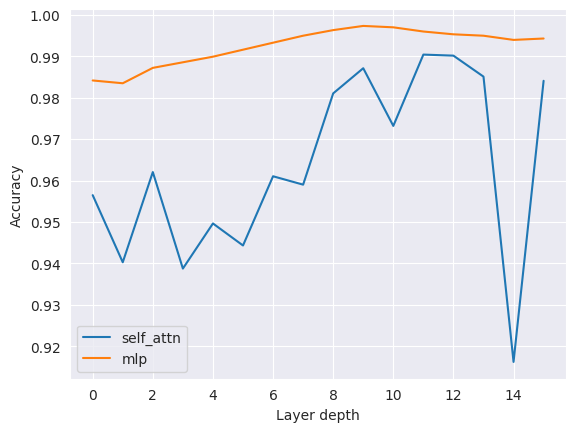

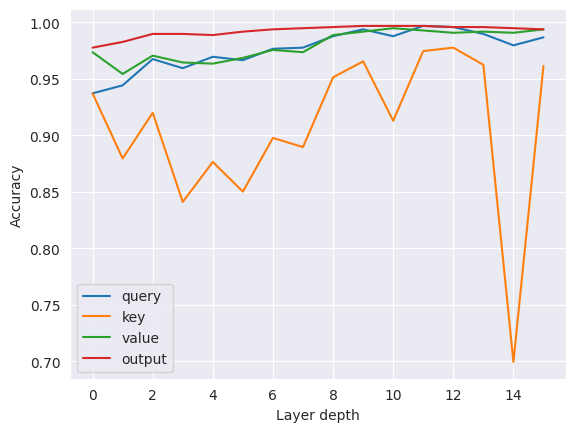

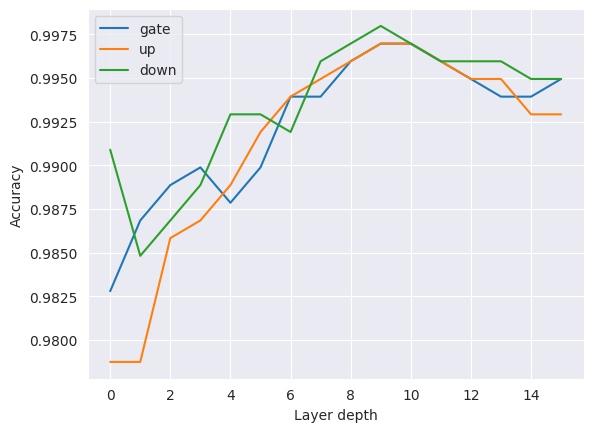

In [81]:
plot_olmo_layer_component_accuracy(
    accuracy_per_layer_paraphrased,
    model_to_evaluate,
    sample_size,
    ExperimentType.PARAPHRASED,
)

In [82]:
accuracy_per_layer_paraphrased

{'model.embed_tokens.weight': 0.992914979757085,
 'model.layers.0.self_attn.q_proj.weight': 0.937246963562753,
 'model.layers.0.self_attn.k_proj.weight': 0.937246963562753,
 'model.layers.0.self_attn.v_proj.weight': 0.9736842105263158,
 'model.layers.0.self_attn.o_proj.weight': 0.9777327935222672,
 'model.layers.0.mlp.gate_proj.weight': 0.9827935222672065,
 'model.layers.0.mlp.up_proj.weight': 0.978744939271255,
 'model.layers.0.mlp.down_proj.weight': 0.9908906882591093,
 'model.layers.1.self_attn.q_proj.weight': 0.944331983805668,
 'model.layers.1.self_attn.k_proj.weight': 0.8795546558704453,
 'model.layers.1.self_attn.v_proj.weight': 0.9544534412955465,
 'model.layers.1.self_attn.o_proj.weight': 0.9827935222672065,
 'model.layers.1.mlp.gate_proj.weight': 0.9868421052631579,
 'model.layers.1.mlp.up_proj.weight': 0.978744939271255,
 'model.layers.1.mlp.down_proj.weight': 0.9848178137651822,
 'model.layers.2.self_attn.q_proj.weight': 0.9676113360323887,
 'model.layers.2.self_attn.k_proj

In [83]:
avg_by_component(accuracy_per_layer_paraphrased, np.mean)

{'embed_tokens': 0.993,
 'self_attn.q_proj': 0.976,
 'self_attn.k_proj': 0.906,
 'self_attn.v_proj': 0.98,
 'self_attn.o_proj': 0.992,
 'mlp.gate_proj': 0.992,
 'mlp.up_proj': 0.991,
 'mlp.down_proj': 0.993}

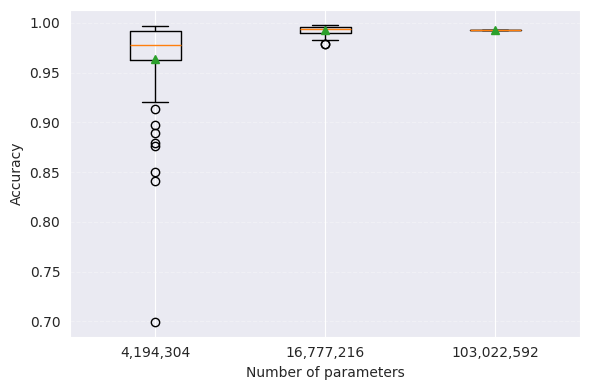

In [84]:
create_accuracy_per_layer_boxplot(
    accuracy_per_layer_paraphrased,
    num_parameters_per_layer,
    model_to_evaluate,
    sample_size,
    ExperimentType.PARAPHRASED
)

### 1.1.1 Example Similarities over Layers

In [85]:
layer_with_best_score_paraphrased = max(accuracy_per_layer_paraphrased, key=accuracy_per_layer_paraphrased.get)
layer_with_best_score_paraphrased

'model.layers.9.mlp.down_proj.weight'

In [86]:
examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased = find_top_k_examples_where_similarity_diverges_between_single_layer_gradient_and_full_gradient(layer_with_best_score_paraphrased, cosine_similarities_new_structure_paraphrased, cosine_similarities_old_structure_combined_paraphrased)

In [87]:
examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased

['lima_802', 'lima_815', 'lima_849']

In [88]:
for sample in get_samples(examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased):
    original_user_message = sample["messages"][0]["content"].replace("\n", "\n\t\t")
    original_assistant_message = sample["messages"][1]["content"].replace("\n", "\n\t\t")

    paraphrased_user_message = sample['paraphrased_messages'][0]['content'].replace("\n", "\n\t\t")
    paraphrased_assistant_message = sample['paraphrased_messages'][1]['content'].replace("\n", "\n\t\t")


    print(f"============{sample['id']}============")
    print("original:")
    print("\tuser message:")
    print(f"\t\t{original_user_message}")
    print()
    print("\tassistant message:")
    print(f"\t\t{original_assistant_message}")

    print("-----")

    print("paraphrased:")
    print("\tuser message:")
    print(f"\t\t{paraphrased_user_message}")
    print()
    print("\tassistant message:")
    print(f"\t\t{paraphrased_assistant_message}")

============lima_802============
original:
	user message:
		Translate the following text into English.
		
		人们应该尊重不同的文化和信仰，互相理解和包容。

	assistant message:
		People should respect different cultures and beliefs and understand and tolerate each other.
-----
paraphrased:
	user message:
		People should respect different cultures and beliefs, and understand and tolerate each other.

	assistant message:
		Individuals ought to honor various cultures and beliefs while seeking to comprehend and accept one another.
============lima_815============
original:
	user message:
		Rewrite the sentence in order to make it easier to understand by non-native speakers of English. You can do so by replacing complex words with simpler synonyms (i.e. paraphrasing), deleting unimportant information (i.e. compression), and/or splitting a long complex sentence into several simpler ones. The final simplified sentences need to be grammatical, fluent, and retain the main ideas of their original counterparts without a

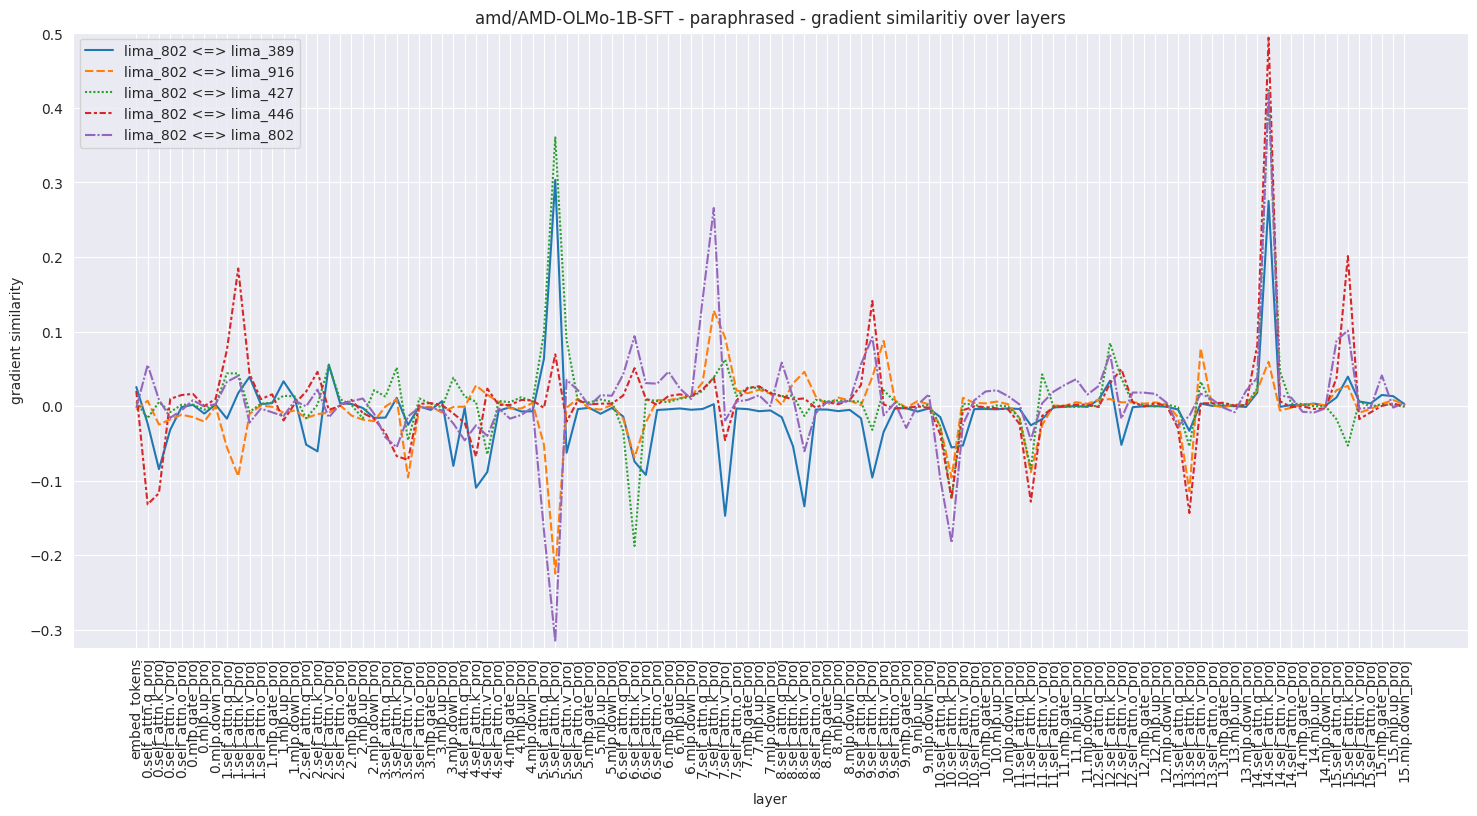

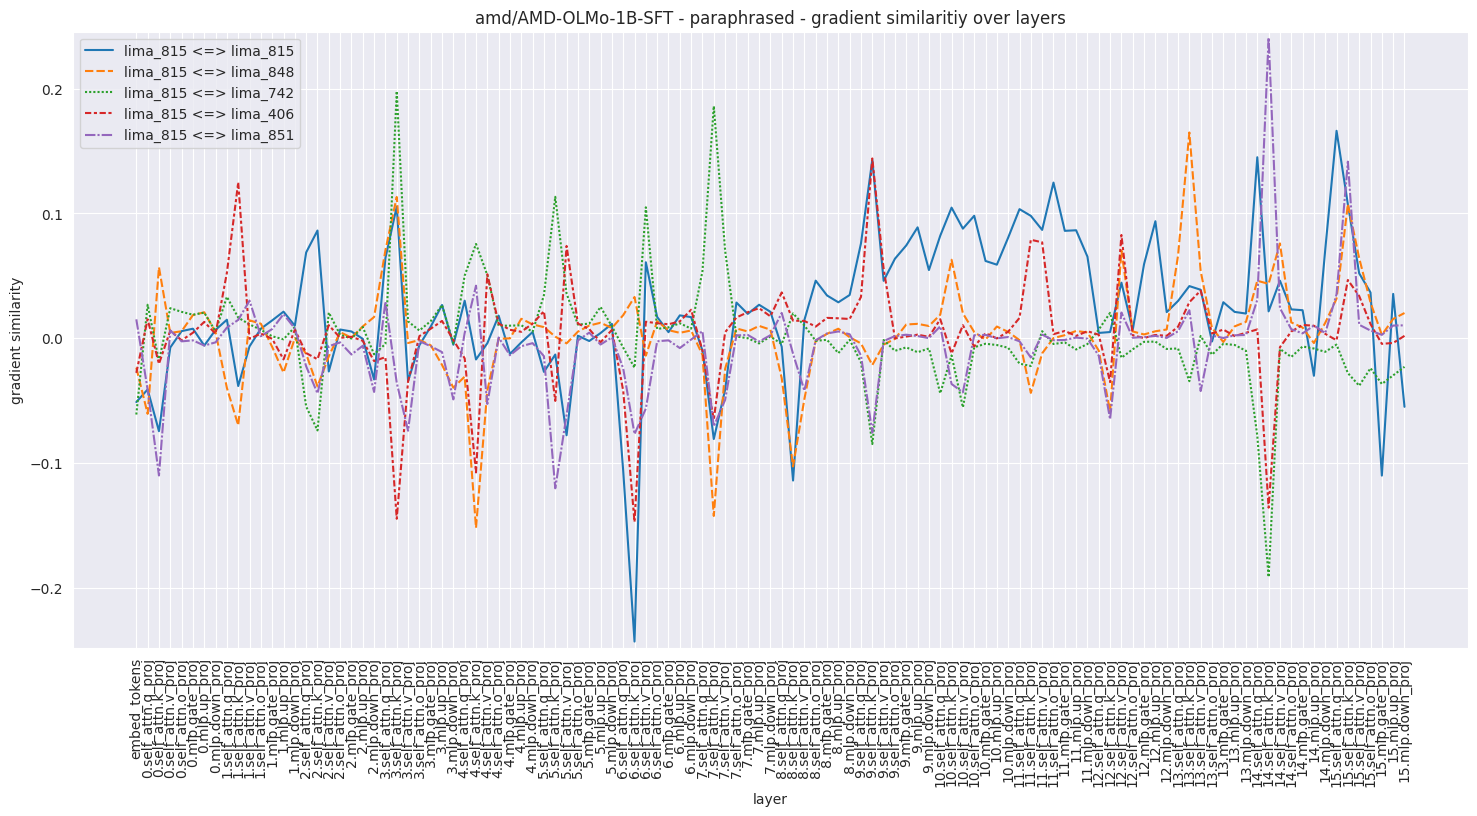

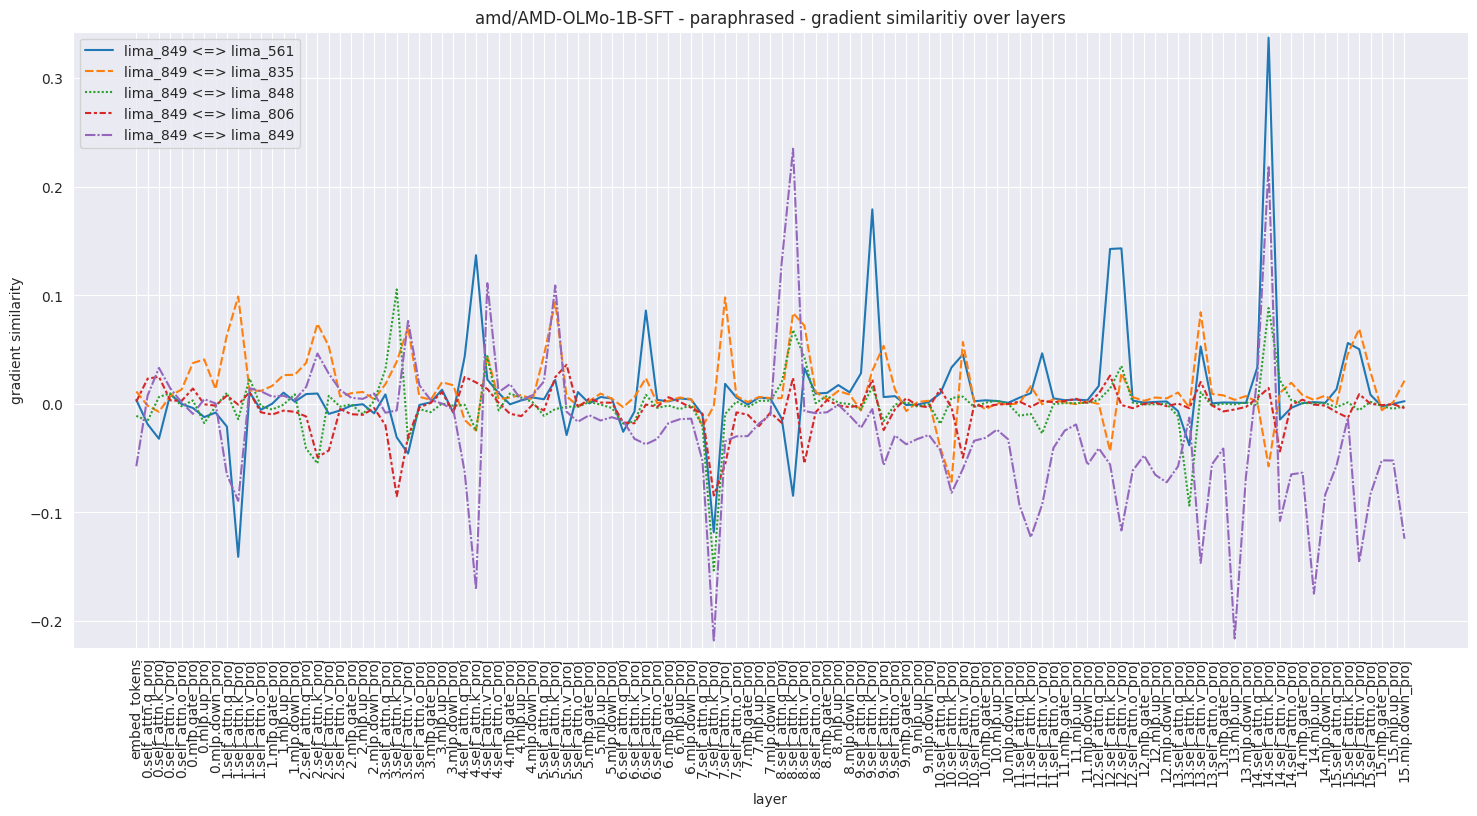

In [89]:
plot_gradient_similarities_over_layers(
    examples=examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased,
    gradient_similarities_per_layer_old_structure=cosine_similarities_old_structure_paraphrased,
    title=f"{model_to_evaluate} - paraphrased - gradient similaritiy over layers",
    experiment_type=ExperimentType.PARAPHRASED
)

### 1.1.2 Greedy Layer Selection by Accuracy

In [90]:
greedily_selected_layers_by_acc_paraphrased = greedy_forward_layer_selection_by_accuracy(layer_dot_products_paraphrased)

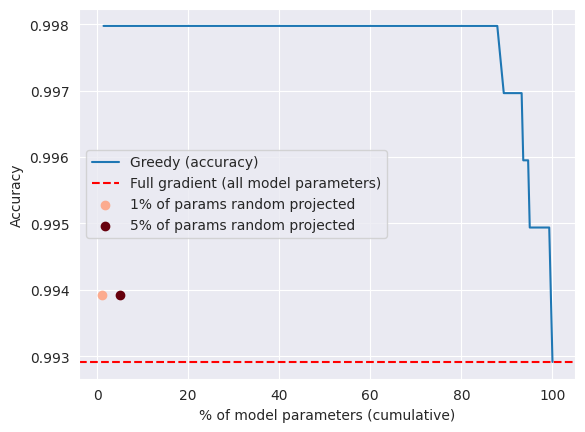

In [91]:
create_accumulated_accuracy_plot_for_greedy_forward_layer_selection(
    greedily_selected_layers_by_acc_paraphrased,
    model,
    num_parameters_per_layer,
    model_to_evaluate,
    sample_size,
    ExperimentType.PARAPHRASED,
    get_gradient_similarity_paraphrased_random_projection_data,
    model_score
)

## 1.2 Comparison between Layer-Gradient-Similarities and Full-Gradient-Similarities

In [92]:
layer_similarity_compared_to_full_gradients_paraphrased = calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(cosine_similarities_new_structure_paraphrased, cosine_similarities_old_structure_combined_paraphrased)

In [93]:
max(layer_similarity_compared_to_full_gradients_paraphrased, key=layer_similarity_compared_to_full_gradients_paraphrased.get)

'model.layers.6.mlp.up_proj.weight'

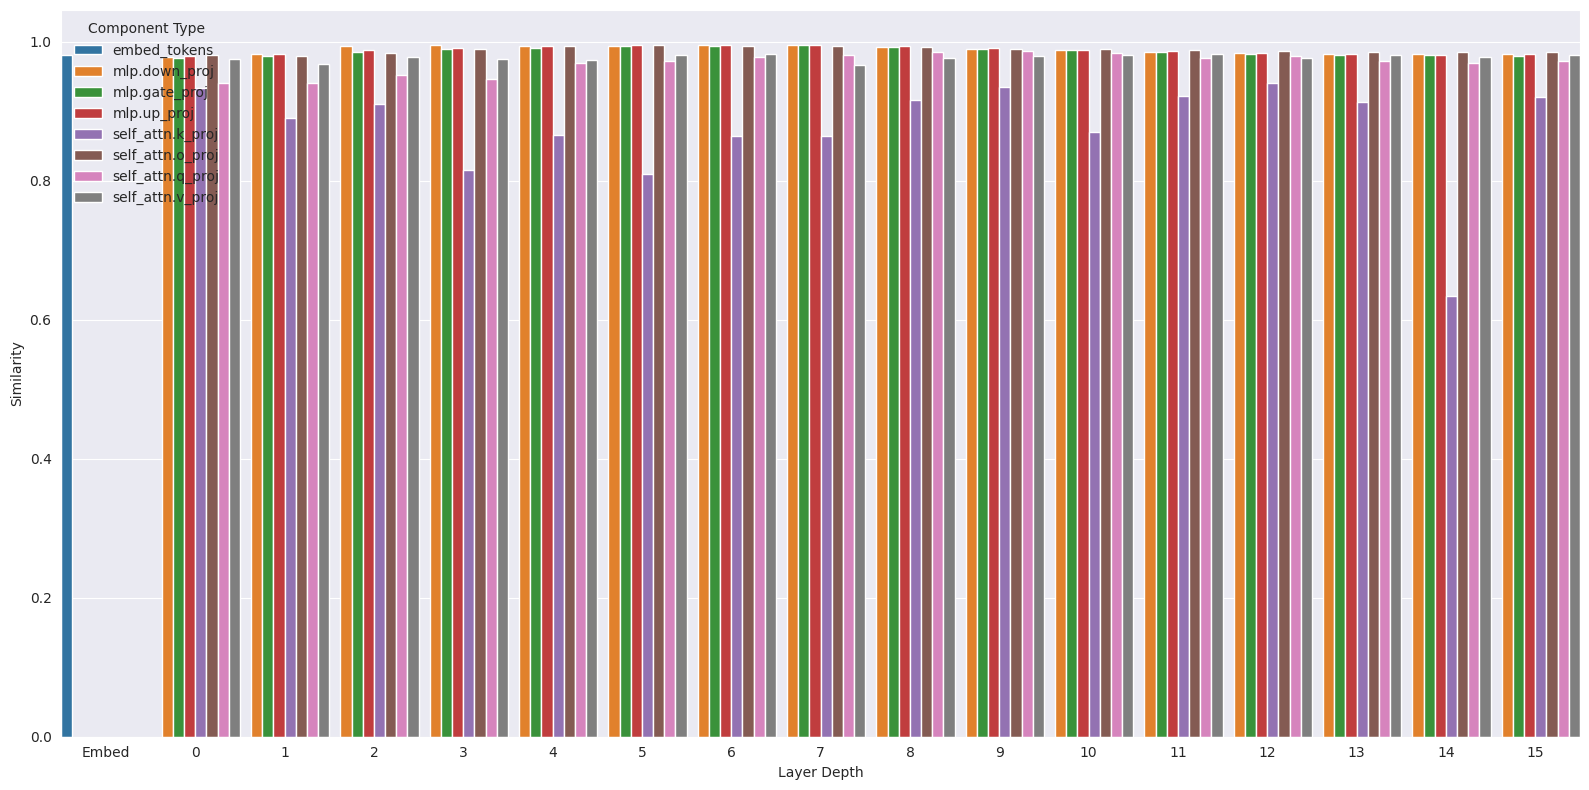

In [94]:
bar_plot(
    y=list(layer_similarity_compared_to_full_gradients_paraphrased.keys()),
    x=list(layer_similarity_compared_to_full_gradients_paraphrased.values()),
    title=f"{model_to_evaluate} - paraphrased - similarity per layer compared to full gradients",
    storage_folder_path=get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED),
    y_axis_label="Similarity"
)

with open(f"{get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED)}/values.json", "w") as f:
    json.dump(layer_similarity_compared_to_full_gradients_paraphrased, f, indent=4)

In [95]:
avg_by_component(layer_similarity_compared_to_full_gradients_paraphrased, np.mean)

{'embed_tokens': 0.981,
 'self_attn.q_proj': 0.969,
 'self_attn.k_proj': 0.875,
 'self_attn.v_proj': 0.977,
 'self_attn.o_proj': 0.988,
 'mlp.gate_proj': 0.986,
 'mlp.up_proj': 0.988,
 'mlp.down_proj': 0.988}

### 1.2.1 Greedy Layer Selection based on Full-Gradient-Comparison

In [96]:
greedily_selected_layers_paraphrased = greedy_forward_layer_selection(layer_dot_products_paraphrased, cosine_similarities_old_structure_combined_paraphrased)

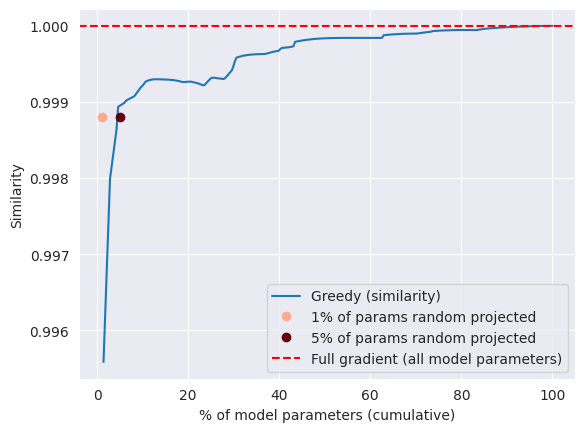

In [97]:
create_accumulated_plot_for_greedy_forward_layer_selection(
    greedily_selected_layers_paraphrased,
    get_gradient_similarity_paraphrased_random_projection_data,
    cosine_similarities_old_structure_combined_paraphrased,
    model_to_evaluate,
    sample_size,
    ExperimentType.PARAPHRASED
)

# 2. BM25 Selected Model Generated

In [98]:
cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_model_generated, cosine_similarities_old_structure_combined_model_generated, layer_dot_products_model_generated = get_cosine_similarities(get_dot_product_model_generated_files, model_to_evaluate, sample_size)

In [99]:
model_score_model_generated, bm25_score_model_generated = calculate_score(cosine_similarities_old_structure_combined_model_generated)
wrong_decisions_model_generated = get_wrong_decisions(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_score_median_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated, np.median)

print(f"Model score: {model_score_model_generated}")
print(f"BM25 score: {bm25_score_model_generated}")
print(f"Mean similarity (average): {mean_similarity_model_generated}")
print(f"Mean similarity (median): {mean_similarity_score_median_model_generated}")

Model score: 0.21761133603238866
BM25 score: 0.8360323886639676
Mean similarity (average): 0.018380379908200538
Mean similarity (median): 0.012993619464051021


## 2.1 Layer Analysis

In [100]:
accuracy_per_layer_model_generated = calculate_accuracy_per_layer(cosine_similarities_new_structure_model_generated)

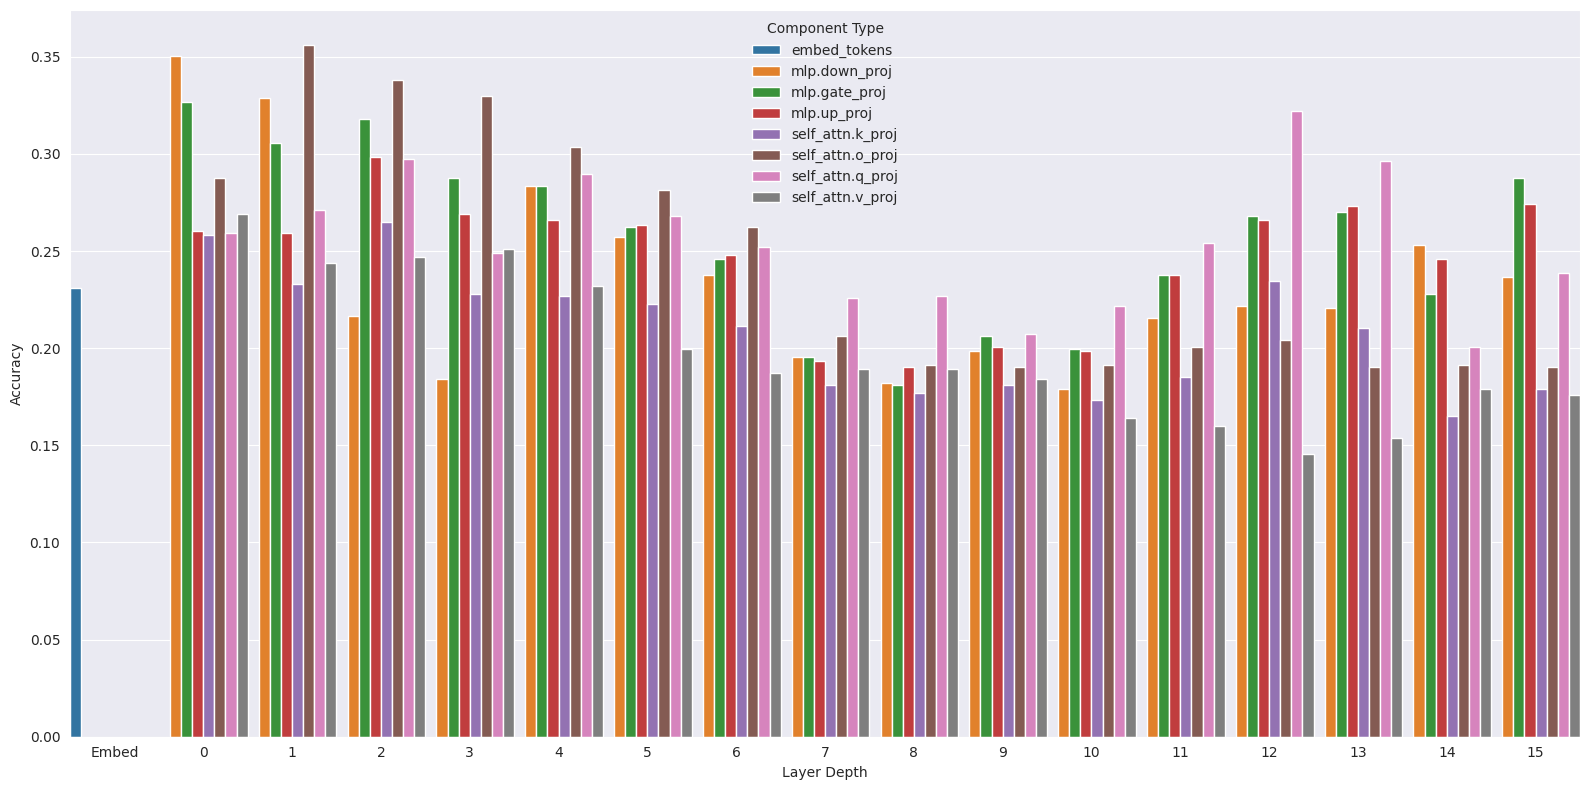

In [101]:
bar_plot(
    y=list(accuracy_per_layer_model_generated.keys()),
    x=list(accuracy_per_layer_model_generated.values()),
    title=f"{model_to_evaluate} - model generated - accuracy per layer",
    storage_folder_path=get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED),
    y_axis_label="Accuracy"
)

with open(f"{get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED)}/values.json", "w") as f:
    json.dump(accuracy_per_layer_model_generated, f, indent=4)

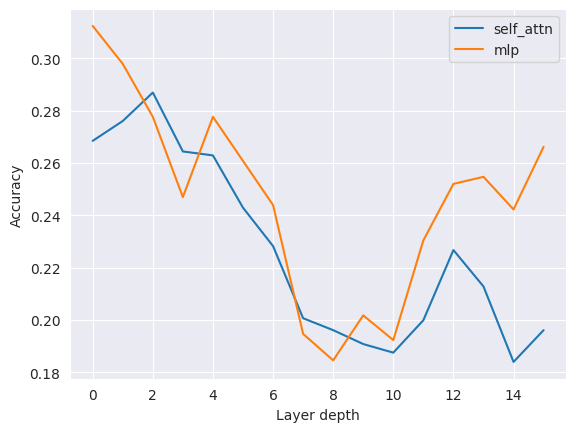

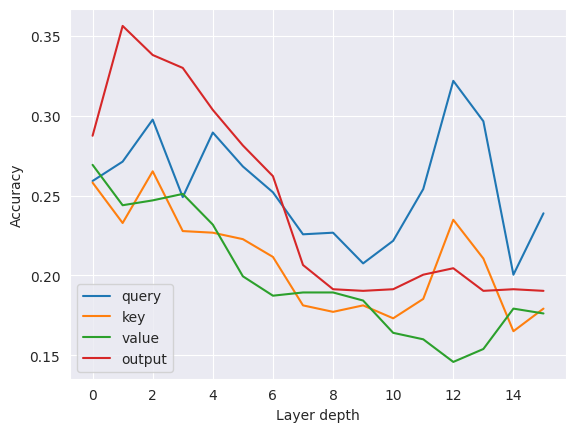

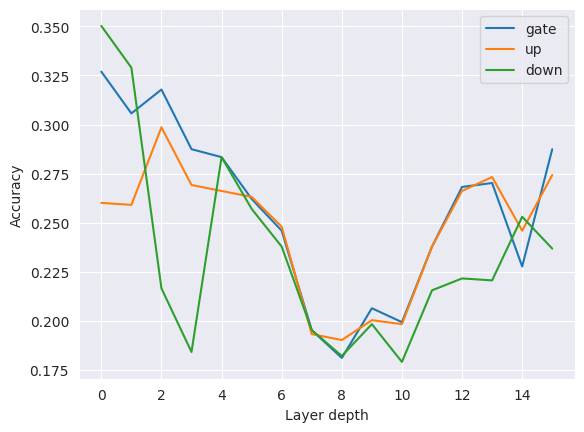

In [102]:
plot_olmo_layer_component_accuracy(
    accuracy_per_layer_model_generated,
    model_to_evaluate,
    sample_size,
    ExperimentType.MODEL_GENERATED,
)

In [103]:
accuracy_per_layer_model_generated

{'model.embed_tokens.weight': 0.23076923076923078,
 'model.layers.0.self_attn.q_proj.weight': 0.2591093117408907,
 'model.layers.0.self_attn.k_proj.weight': 0.25809716599190285,
 'model.layers.0.self_attn.v_proj.weight': 0.2692307692307692,
 'model.layers.0.self_attn.o_proj.weight': 0.2874493927125506,
 'model.layers.0.mlp.gate_proj.weight': 0.3269230769230769,
 'model.layers.0.mlp.up_proj.weight': 0.2601214574898785,
 'model.layers.0.mlp.down_proj.weight': 0.35020242914979755,
 'model.layers.1.self_attn.q_proj.weight': 0.27125506072874495,
 'model.layers.1.self_attn.k_proj.weight': 0.23279352226720648,
 'model.layers.1.self_attn.v_proj.weight': 0.24392712550607287,
 'model.layers.1.self_attn.o_proj.weight': 0.3562753036437247,
 'model.layers.1.mlp.gate_proj.weight': 0.305668016194332,
 'model.layers.1.mlp.up_proj.weight': 0.2591093117408907,
 'model.layers.1.mlp.down_proj.weight': 0.32894736842105265,
 'model.layers.2.self_attn.q_proj.weight': 0.2975708502024291,
 'model.layers.2.self

In [104]:
avg_by_component(accuracy_per_layer_model_generated, np.mean)

{'embed_tokens': 0.231,
 'self_attn.q_proj': 0.255,
 'self_attn.k_proj': 0.208,
 'self_attn.v_proj': 0.198,
 'self_attn.o_proj': 0.245,
 'mlp.gate_proj': 0.256,
 'mlp.up_proj': 0.247,
 'mlp.down_proj': 0.235}

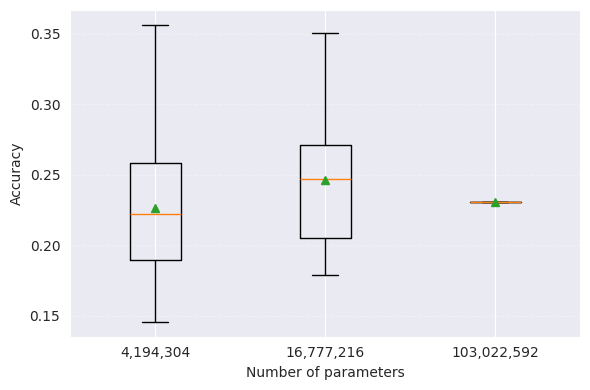

In [105]:
create_accuracy_per_layer_boxplot(
    accuracy_per_layer_model_generated,
    num_parameters_per_layer,
    model_to_evaluate,
    sample_size,
    ExperimentType.MODEL_GENERATED
)

### 2.1.1 Example Similarities over Layers

In [106]:
layer_with_best_score_model_generated = max(accuracy_per_layer_model_generated, key=accuracy_per_layer_model_generated.get)
layer_with_best_score_model_generated

'model.layers.1.self_attn.o_proj.weight'

In [107]:
examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_model_generated = find_top_k_examples_where_similarity_diverges_between_single_layer_gradient_and_full_gradient(
    layer_with_best_score_model_generated,
    cosine_similarities_new_structure_model_generated,
    cosine_similarities_old_structure_combined_model_generated
)

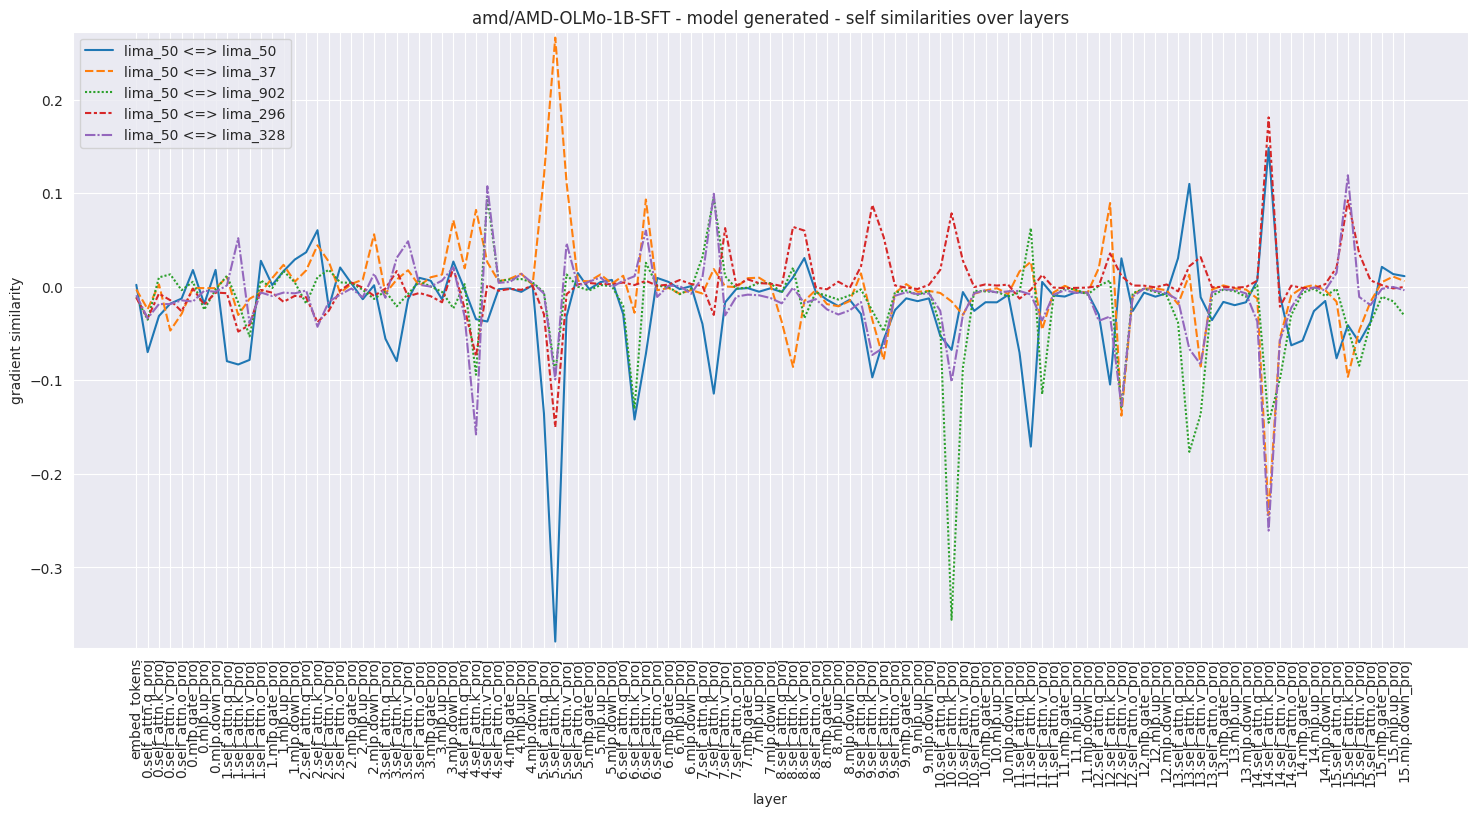

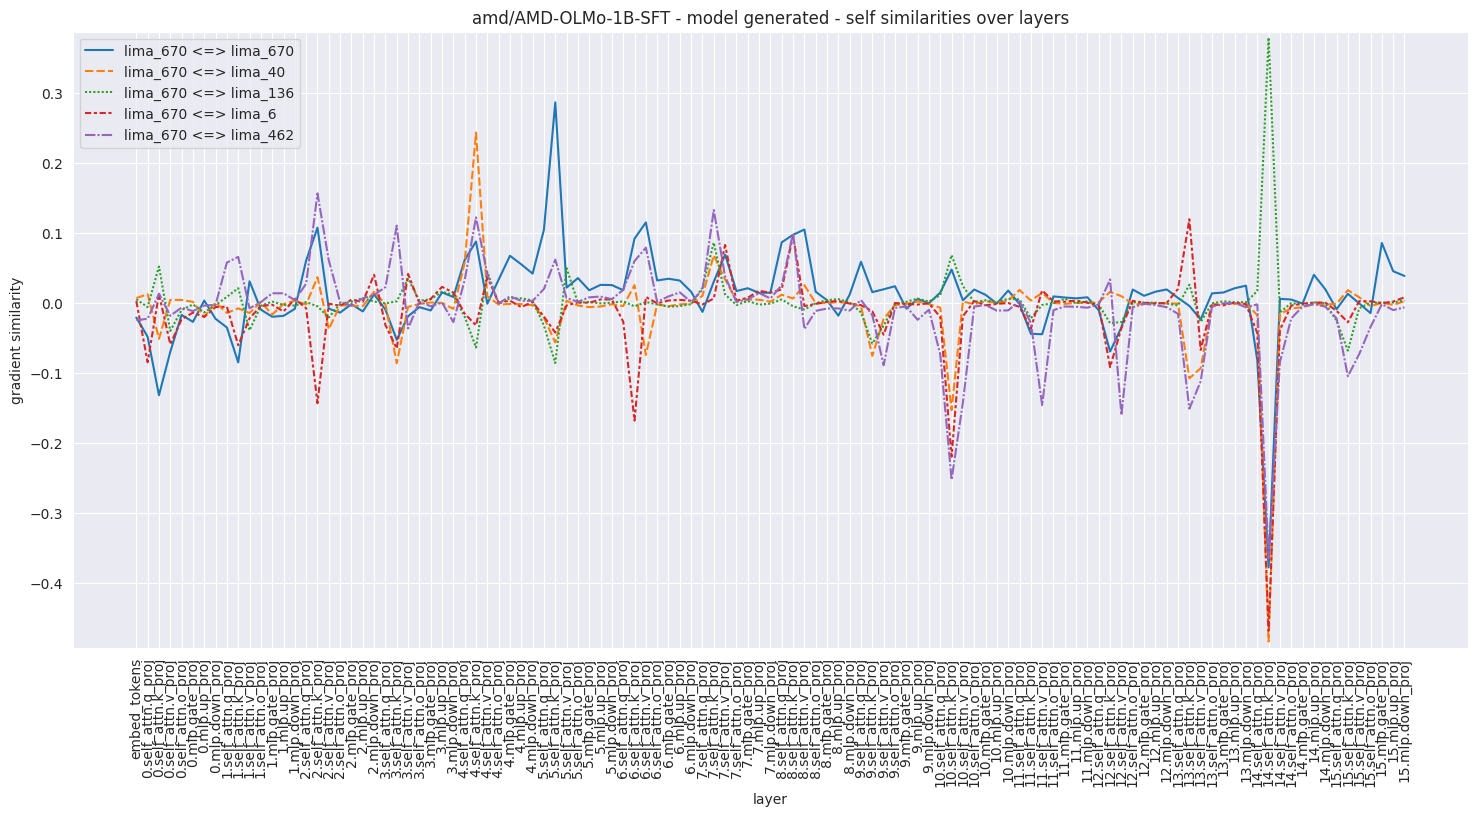

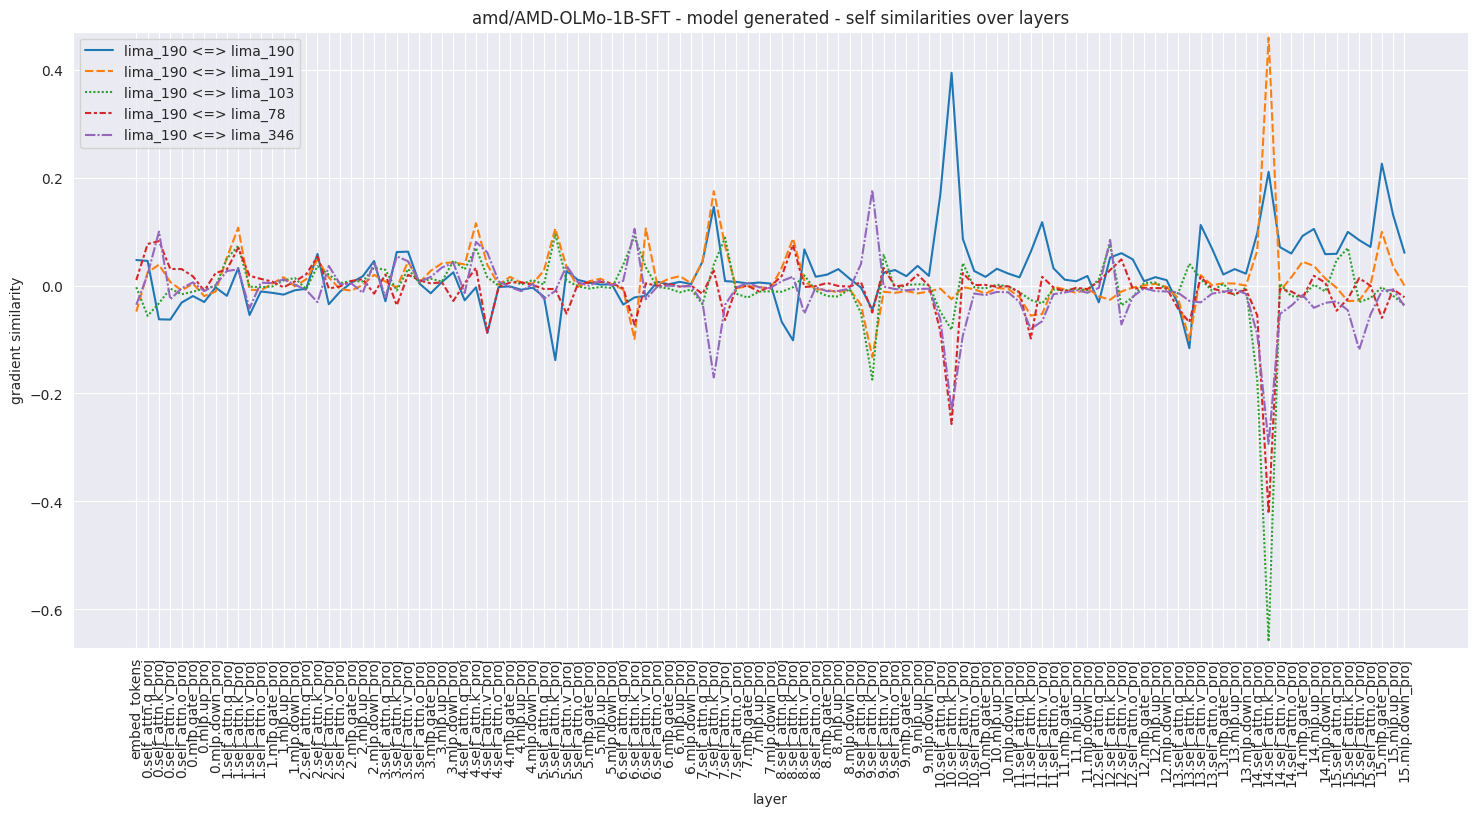

In [108]:
plot_gradient_similarities_over_layers(
    examples=examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_model_generated,
    gradient_similarities_per_layer_old_structure=cosine_similarities_old_structure_model_generated,
    title=f"{model_to_evaluate} - model generated - self similarities over layers",
    experiment_type=ExperimentType.MODEL_GENERATED
)

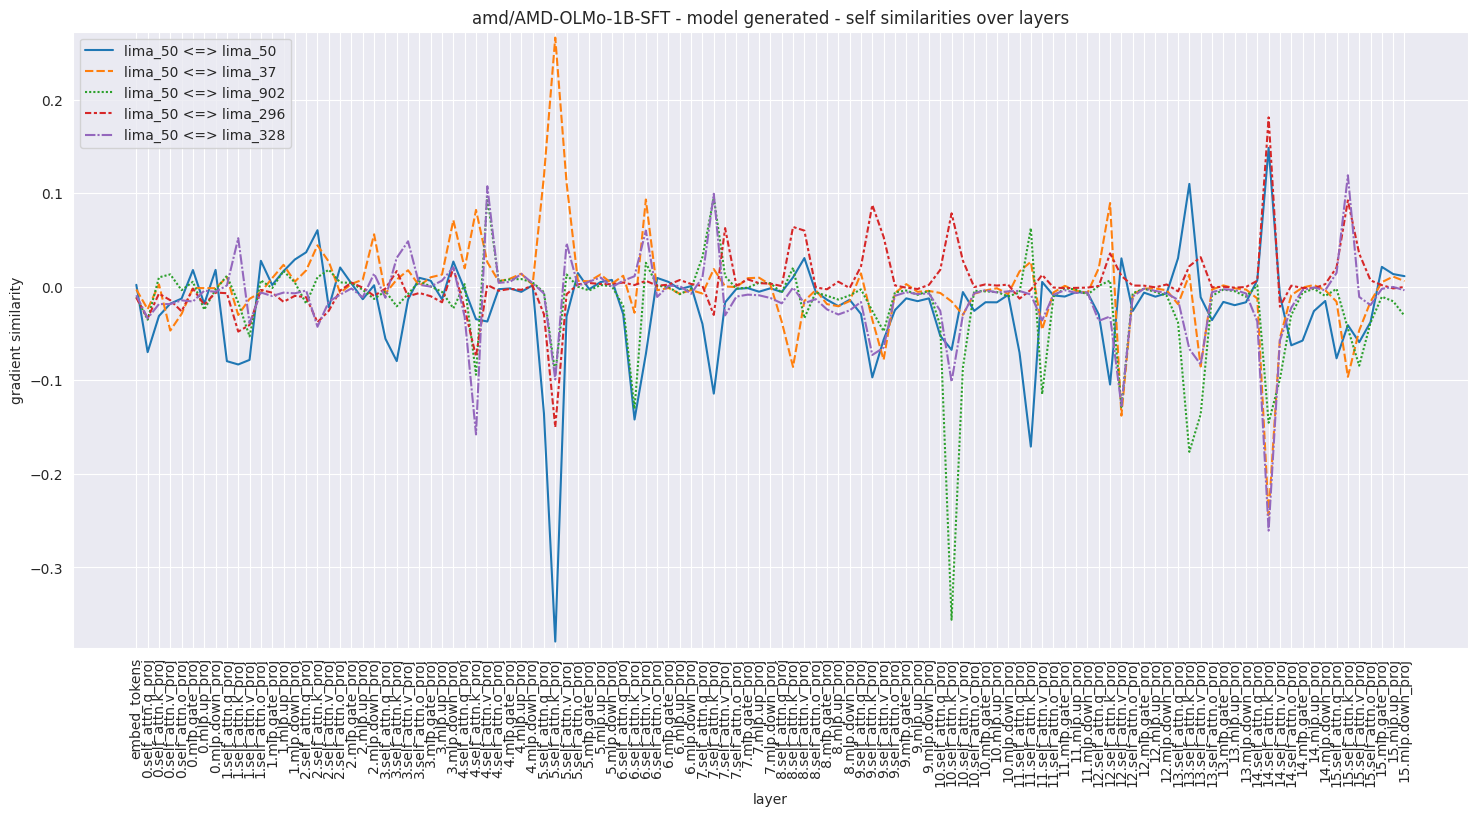

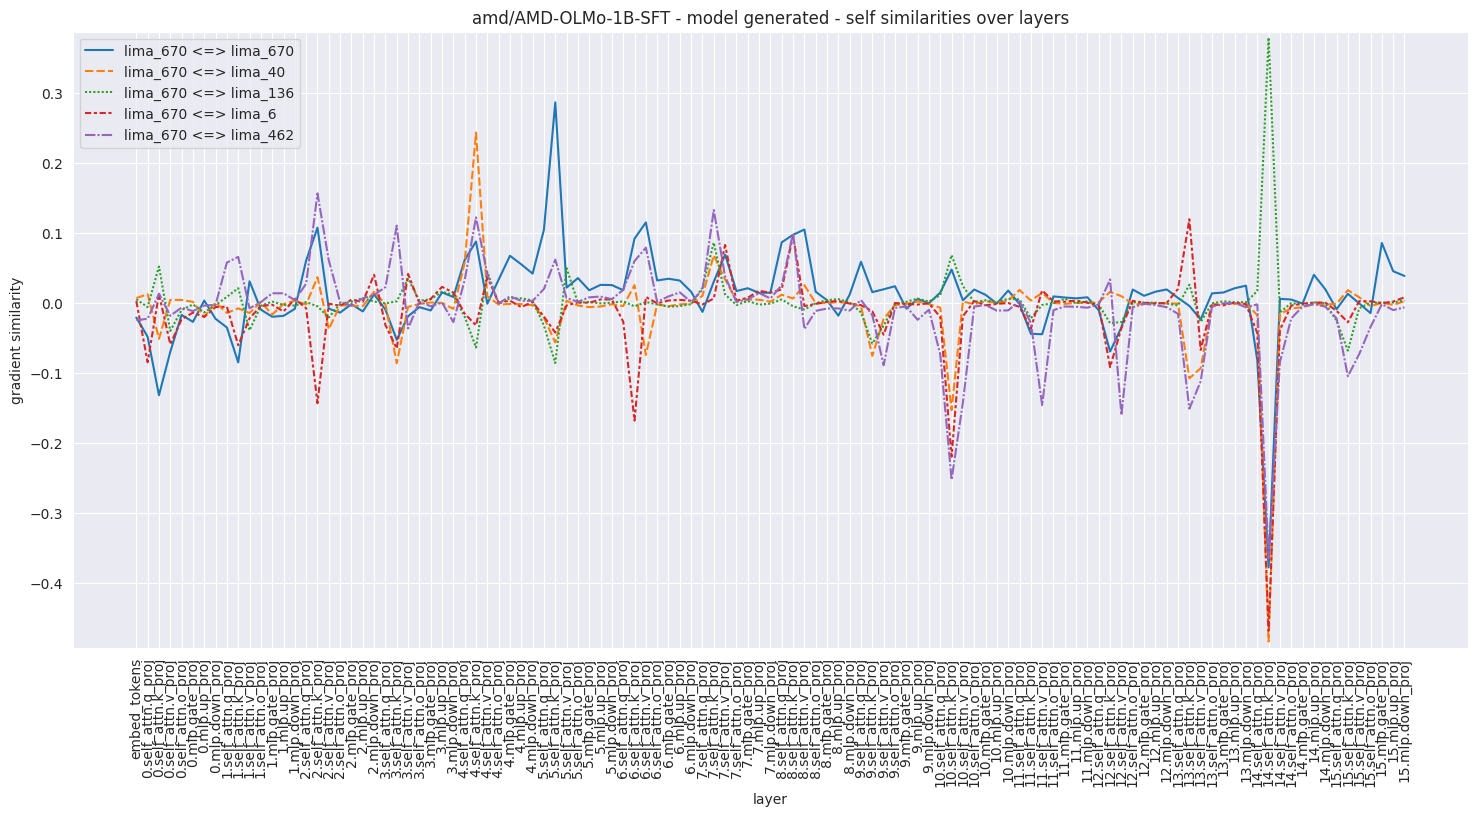

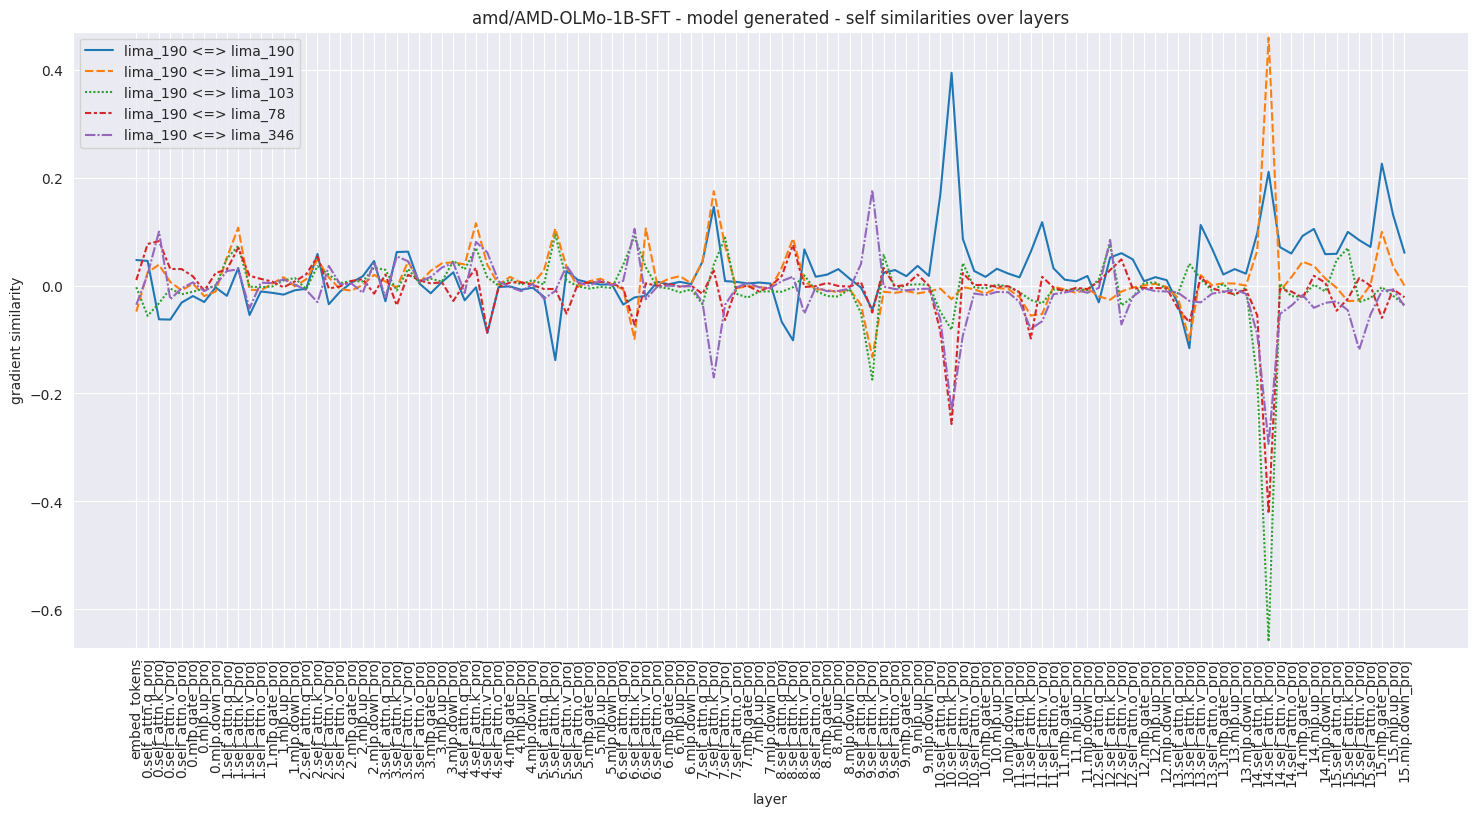

In [109]:
plot_gradient_similarities_over_layers(
    examples=examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_model_generated,
    gradient_similarities_per_layer_old_structure=cosine_similarities_old_structure_model_generated,
    title=f"{model_to_evaluate} - model generated - self similarities over layers",
    experiment_type=ExperimentType.MODEL_GENERATED
)

### 2.1.2 Greedy Layer Selection by Accuracy

In [110]:
greedily_selected_layers_by_acc_model_generated = greedy_forward_layer_selection_by_accuracy(layer_dot_products_model_generated)

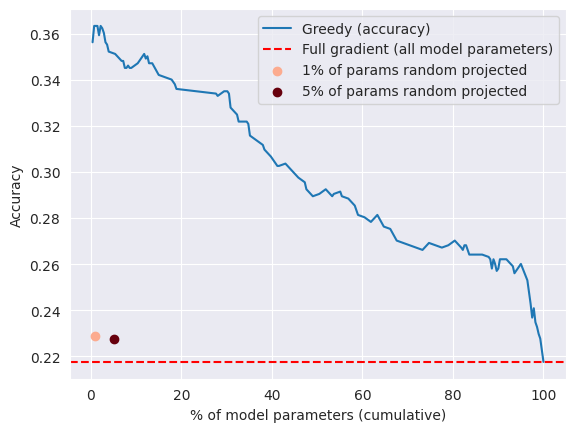

In [111]:
create_accumulated_accuracy_plot_for_greedy_forward_layer_selection(
    greedily_selected_layers_by_acc_model_generated,
    model,
    num_parameters_per_layer,
    model_to_evaluate,
    sample_size,
    ExperimentType.MODEL_GENERATED,
    get_gradient_similarity_model_generated_random_projection_data,
    model_score_model_generated
)

## 2.2 Comparison between Layer-Gradient-Similarities and Full-Gradient-Similarities

In [112]:
layer_similarity_compared_to_full_gradients_model_generated = calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_combined_model_generated)

In [113]:
max(layer_similarity_compared_to_full_gradients_model_generated, key=layer_similarity_compared_to_full_gradients_model_generated.get)

'model.layers.3.mlp.down_proj.weight'

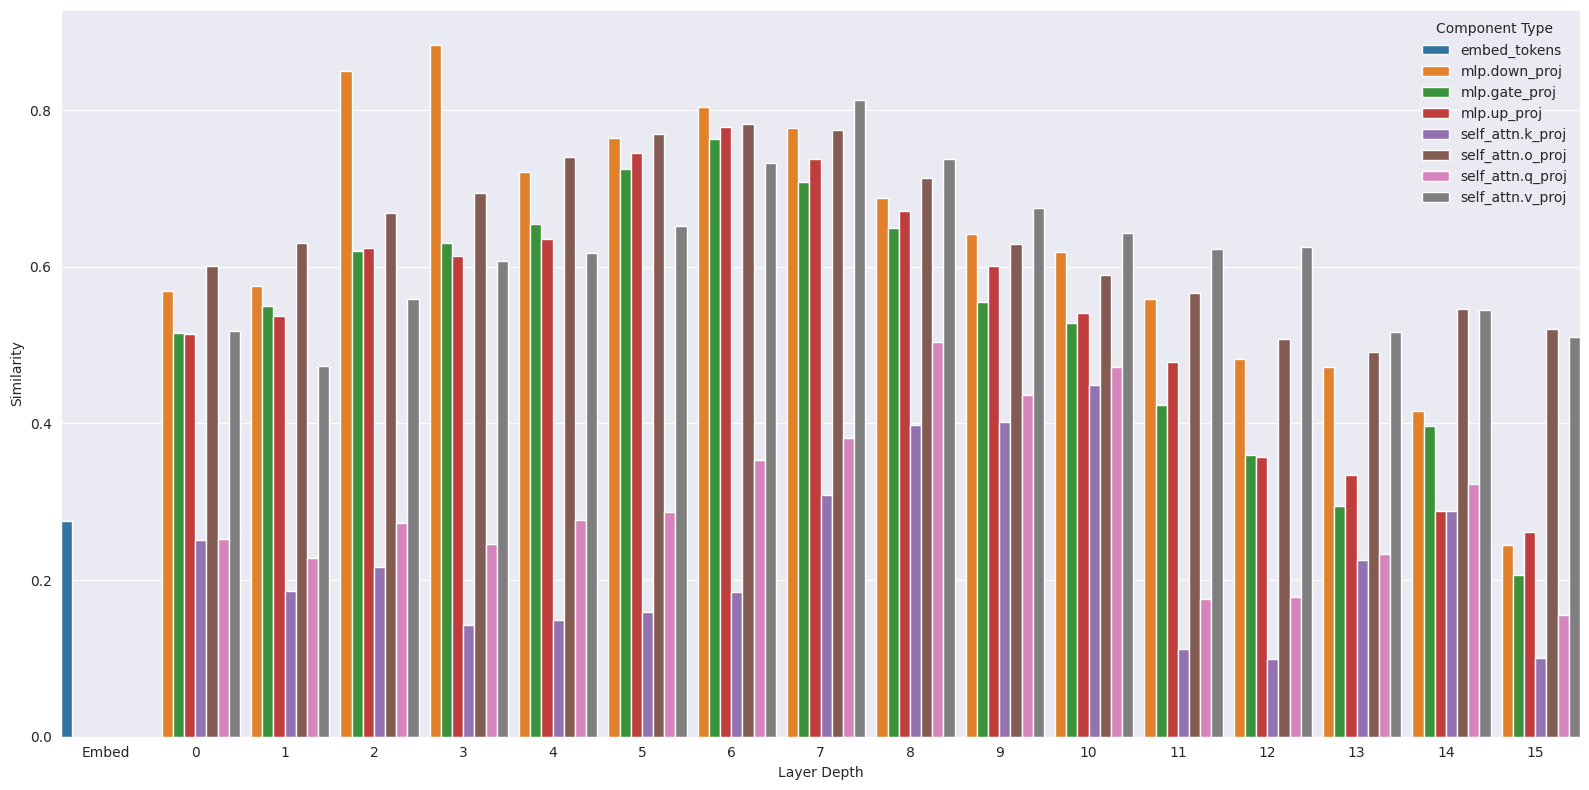

In [114]:
bar_plot(
    y=list(layer_similarity_compared_to_full_gradients_model_generated.keys()),
    x=list(layer_similarity_compared_to_full_gradients_model_generated.values()),
    title=f"{model_to_evaluate} - model generated - similarity per layer compared to full gradients",
    storage_folder_path=get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED),
    y_axis_label="Similarity"
)

with open(f"{get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED)}/values.json", "w") as f:
    json.dump(layer_similarity_compared_to_full_gradients_model_generated, f, indent=4)

In [115]:
avg_by_component(layer_similarity_compared_to_full_gradients_model_generated, np.mean)

{'embed_tokens': 0.275,
 'self_attn.q_proj': 0.298,
 'self_attn.k_proj': 0.229,
 'self_attn.v_proj': 0.615,
 'self_attn.o_proj': 0.639,
 'mlp.gate_proj': 0.536,
 'mlp.up_proj': 0.545,
 'mlp.down_proj': 0.629}

### 2.2.1 Greedy Layer Selection based on Full-Gradient-Comparison

In [116]:
greedily_selected_layers_model_generated = greedy_forward_layer_selection(layer_dot_products_model_generated, cosine_similarities_old_structure_combined_model_generated)

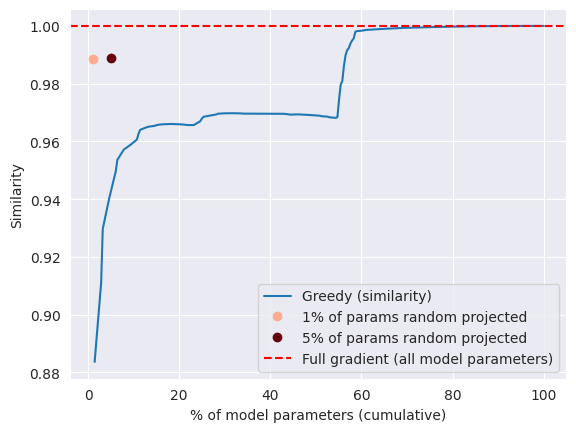

In [117]:
create_accumulated_plot_for_greedy_forward_layer_selection(
    greedily_selected_layers_model_generated,
    get_gradient_similarity_model_generated_random_projection_data,
    cosine_similarities_old_structure_combined_model_generated,
    model_to_evaluate,
    sample_size,
    ExperimentType.MODEL_GENERATED
)

# 3. Accuracy Comparison

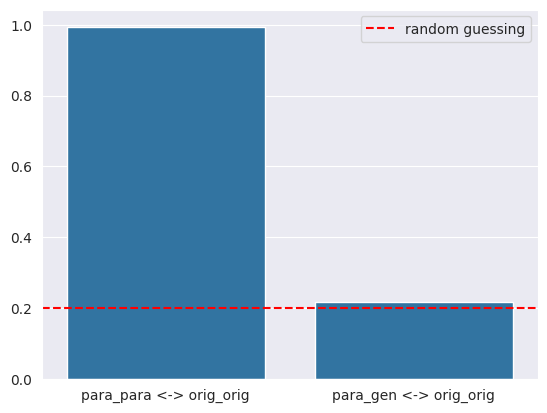

In [118]:
# create bar plot with paraphrased_score, paraphrased_model_generated_score, and horizontal line at 0.2 baseline
sns.barplot(x=["para_para <-> orig_orig", "para_gen <-> orig_orig"], y=[model_score, model_score_model_generated])

plt.axhline(y=0.2, color='r', linestyle='--', label="random guessing")
plt.legend()
plt.show()